In [105]:
#import modules
#standard libraries
import numpy as np
import statistics
import random
import itertools
from IPython.display import display, clear_output

#learning and evalution modules
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#signal analysis
from scipy import signal
from scipy.io import wavfile
import librosa

#plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize


### Motivation
**Overview**: In this project we explore whether we can classify different object using vibration data collected from a robot hand interacting with those objects. We make use of Hidden Markov Models for classification. The development of algorithms for acoustic-based object classification can enable the sensorization of robots with low-cost microphones and speakers.

**Background**: Robots are equipped with a variety of sensors that allow them to interact with objects in there surroundings and that help inform higher-level control and planning decisions. In general, there are two major sensing modalities for robots: vision-based and tactile-based. Vision-based sensors rely on cameras and ranging instruments to directly visualize the robot's environment and localize landmarks (e.g. tags, markers).One of the main drawbacks of cameras and ranging instruments is that they suffer from occlusions. Another issue is that processing point-clouds and images for feature extraction and object detection can be challenging, especially in the presence of varying lighting conditions and shadows. In contrast to vision-based sensors, tactile sensors gather information from physical interactions with objects. Tactile sensors are usually directly mounted to the 'probing' components of the robot (e.g. hand of a robotic manipulator or the wheel of a mobile robot). A common architecture for tactile sensors involves a network of piezo-resistive, capacitive, optical or electromagnetic elements that detect different characteristics of physical interactions (e.g. force, proximity, angle of contact). Recently, tactile sensors based on acoustics have been developed. Acoustic-based tactile sensors have been used for contact localization, force characterization and slip detection [(Chossat, 2020)](#stretch), [(Liu, 2022)](#slip). Recently, research groups have explored using vibrations generated by the interaction of a robots (e.g. mobile robots, manipulators, robotic hands) with different objects to make predictions about the properties of those objects (e.g. texture, hardness) [(Quilachamin, 2023)](#biomimetic_fingerprint), [(Toprak, 2017)](#dataset), [(Roy, 2002)](#dudek). 

**Problem Description**: In this project, I ask the question, *can vibration data, acquired using contact microphones and resulting from the interaction of a robotic hand engaging in exploratory actions with objects, be used to identify these objects*.

**Significance**: Acoustic-based tactile sensors are an intriguing addition to the sensing toolkit of robots since they allow for low-density sensor networks with capabilities such as contact localization and object classification. Real-time object classification can enable robots to adjust interaction dynamics and can help inform task planning (e.g. sorting, pick-and-place), especially in environments where cameras fail due to occlusions. Developing an algorithm that can classify objects in real-time based on vibration data is a critical step in the development pipeline of acoustic-tactile sensors.

**Dataset** [(Toprak, 2017)](#dataset): The dataset consists of vibration data from a robotic hand engaging in exploratory actions with different objects. In each trial, a robotic hand grabs and object and rubs it on a serrated, wooden stick. As seen in **Fig. 1**, several contact microphones are used to acquire vibration data from the interaction of the robotic hand with the object and the stick.

![fig_1](images/setup.png)

**Figure 1:** Setup of the experiment used to acquire the acoustic/vibration data including a robotic hand, a serrated wooden stick on which the objects are rubbed and the contact microphones (two on the robot itself and two on the serrated stick) [(Toprak, 2017)](#dataset).

**Solution Approach/Technique**: Different approaches have been used to classify objects and surfaces textures using vibration data acquired in a variety of setups (e.g. mobile robots, robotic hands, scanning probes, grippers). The most common approaches involve:
1. regression algorithms (e.g. SVM, k-NN) [(Wang, 2022)](#regression), [(Hughes, 2014)](#skin);
2. recurrent neural networks [(Jonetzko, 2020)](#pills);
3. transformers (paired with a CNN) [(Chang, 2023)](#transformer).

The authors of the paper use a growing when required network to predict object classes from vibration and achieve a maximum accuracy of 68.2%. This performance metric will serve as a benchmark for evaluating the performance of the model used in this project.

In this project, we use **Hidden Markov Models (HMMs)** to predict the class of an object based solely on vibration data. Similar to a Markov Model, a HMM is defined by a set of states ($\mathcal{S}$) and transition probabilities (usually represented by a matrix $\mathbf{A}$). What makes HMM unique is that states are **not** directly observable. Instead, we rely on observations ($\mathcal{O}$) to predict the underlying states in the system. Further, we define emission densities ($\mathbf{b}$) which define the probability distribution over the set of observations for each hidden state [(Jurafsky, 2023)](#tb). To apply HMMs for classification, we generate a model (defined by the set $\{\mathbf{A}, \mathbf{b}\}$) for each class using training data. The predicted class of an unlabelled sequence of observations is the one whose model yields the highest likelihood prediction.

HMMs have been widely applied in speech classification tasks [(Gales, 2007)](#speech). For word classification HMMs, the hidden states of the system are phones-which are the basic units of sound that comprise words-and the observations can be microphone data of complete utterances [(Sandsmark, 2010)](#tutorial). In this project we can consider the observations/utterances to be the raw microphone data (vibrations) resulting from the movement of the object over the serrated stick. The hidden states of our system are unique, possibly repetitive features that arise in the acoustic data. These features may be time-series peaks, a set of transient frequencies or any other pattern that we learn from the time and frequency domain representation of the acoustic data. Given the similarity between speech and vibration-based object data, we hypothesis that HMMs can be used to classify object based on vibration data.

#### References

<a id=biomimetic></a>
O. A. J. Quilachamin, “A Biomimetic Fingerprint for Robotic Tactile Sensing,” arXiv e-prints, no. arXiv-2307, Jul. 2023.

<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.

<a id=transformer></a>
E. Chang, “An Investigation of Multi-feature Extraction and Super-resolution with Fast Microphone Arrays,” arXiv e-prints, no. arXiv:2310.00206, Sep. 2023.

<a id=regression></a>
Si Ao Wang, A. Albini, P. Maiolino, F. Mastrogiovanni, and G. Cannata, “Fabric Classification Using a Finger-Shaped Tactile Sensor via Robotic Sliding,” Frontiers in Neurorobotics, vol. 16, Feb. 2022, doi: https://doi.org/10.3389/fnbot.2022.808222.

<a id=skin></a>
D. Hughes and N. Correll, “A soft, amorphous skin that can sense and localize textures,” May 2014, doi: https://doi.org/10.1109/icra.2014.6907101.

<a id=pills></a>
Y. Jonetzko, “Multimodal object analysis with auditory and tactile sensing using recurrent neural networks,” International Conference on Cognitive Systems and Signal Processing, pp. 253–265, 2020.

<a id=dudek></a>
N. Roy, G. Dudek, and P. L. Freedman, “Surface sensing and classification for efficient mobile robot navigation,” Dec. 2002, doi: https://doi.org/10.1109/robot.1996.506874.

<a id=tb></a>
D. Jurafsky and J. Martin, Speech and Language Processing, 3rd ed. 2023.

<a id=stretch></a>
Jean-Baptiste Chossat and Peter B Shull. Soft acoustic waveguides for strain, deformation, localization, and twist measurements. IEEE Sensors Journal, 21(1):222–230, 2020.

<a id=slip></a>
Cheng Liu, Tae Myung Huh, Spencer X Chen, Lingling Lu, Fotis Kopsaftopoulos, Mark R Cutkosky, and Fu-Kuo Chang. Design of active sensing smart skin for incipient slip detection in robotics applications. IEEE/ASME Transactions on Mechatronics, 2022.

<a id=speech></a>
M. Gales and S. Young. The application of Hidden Markov models in speech recognition. Foundations and Trends® in Signal Processing, 1(3), pp. 195–304, doi:10.1561/2000000004. 

<a id=tutorial></a>
Hakon Sandsmark. Isolated-word speech recognition using hidden Markov models. 2010. https://google-code-archive-downloads.storage.googleapis.com/v2/code.google.com/hmm-speech-recognition/report.pdf

### Objects in Dataset
First, we show the objects in the dataset. Visually we recognize that some of these objects have a similar texture and so classification using contact microphone data may not always work. 

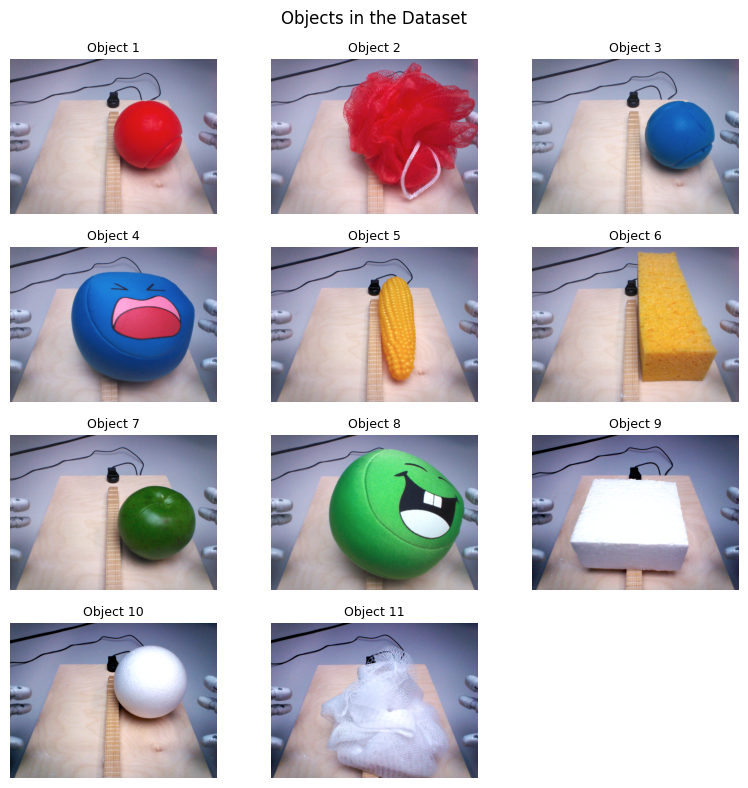

In [89]:
#plot the objects in the dataset
num_rows = 4
num_cols = 3
total_images = num_rows * num_cols
objects = 11

#create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8,8))  # Adjust figsize accordingly
fig.suptitle('Objects in the Dataset')

#initialize a counter for the image index
idx = 0

#iterate through the subdirectories
for object_num in range(1, objects + 1):
    run_ideal_num = 0
    run_ideal_num += 10 * (object_num - 1)
    image_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/foreground.png'
    img = mpimg.imread(image_path)
    i, j = divmod(idx, num_cols)
    axes[i, j].imshow(img)
    axes[i, j].set_title(f'Object {object_num}', fontsize=9)
    axes[i, j].axis('off')
    idx += 1

fig.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

### Initial Analysis of Data
As previously mentioned, our dataset compromises microphone vibration data resulting from the rubbing motion of different objects on a serrated wooden stick. There are 11 objects in the dataset and 13 observations per object [(Toprak, 2017)](#dataset). Ten observations are acquired in what the authors of the dataset call 'ideal' conditions and three in 'real conditions'. According to the authors, under 'real' conditions, "We let the robot perform some of the object exploration runs in a slightly imprecise manner" [(Toprak, 2017)](#dataset).

To be able to classify objects we require there to be differences in either the time or frequency-domain representations of the vibration data. We therefore start by analyzing the data to see if there are differences in the vibration data for each object. To do this we compare the raw audio (time-domain), Mel spectrograms and the Mel frequency cepstral coefficients (MFCCs) for the audio acquired for a given experiment for each object. MFCC components are often used as a frequency-domain representation of audio data in speech and other audio recognition tasks [(Jonetzko, 2020)](#pills), [(Maxime, 2014)](#robots). MFCC components are useful in audio recognition tasks since they provide a good representation of the spectral envelope of a signal while removing finer spectral structure [(Aalto University Wiki)](#wiki.aalto).

#### References

<a id="wiki.aalto"></a>
“Cepstrum and MFCC - Introduction to Speech Processing - Aalto University Wiki,” wiki.aalto.fi. https://wiki.aalto.fi/display/ITSP/Cepstrum+and+MFCC

<a id=pills></a>
Y. Jonetzko, “Multimodal object analysis with auditory and tactile sensing using recurrent neural networks,” International Conference on Cognitive Systems and Signal Processing, pp. 253–265, 2020.

<a id=robots></a>
J. Maxime, X. Alameda-Pineda, L. Girin, and R. Horaud, “Sound representation and classification benchmark for domestic robots,” IEEE Xplore, May 01, 2014. https://ieeexplore.ieee.org/abstract/document/6907786/.

<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.

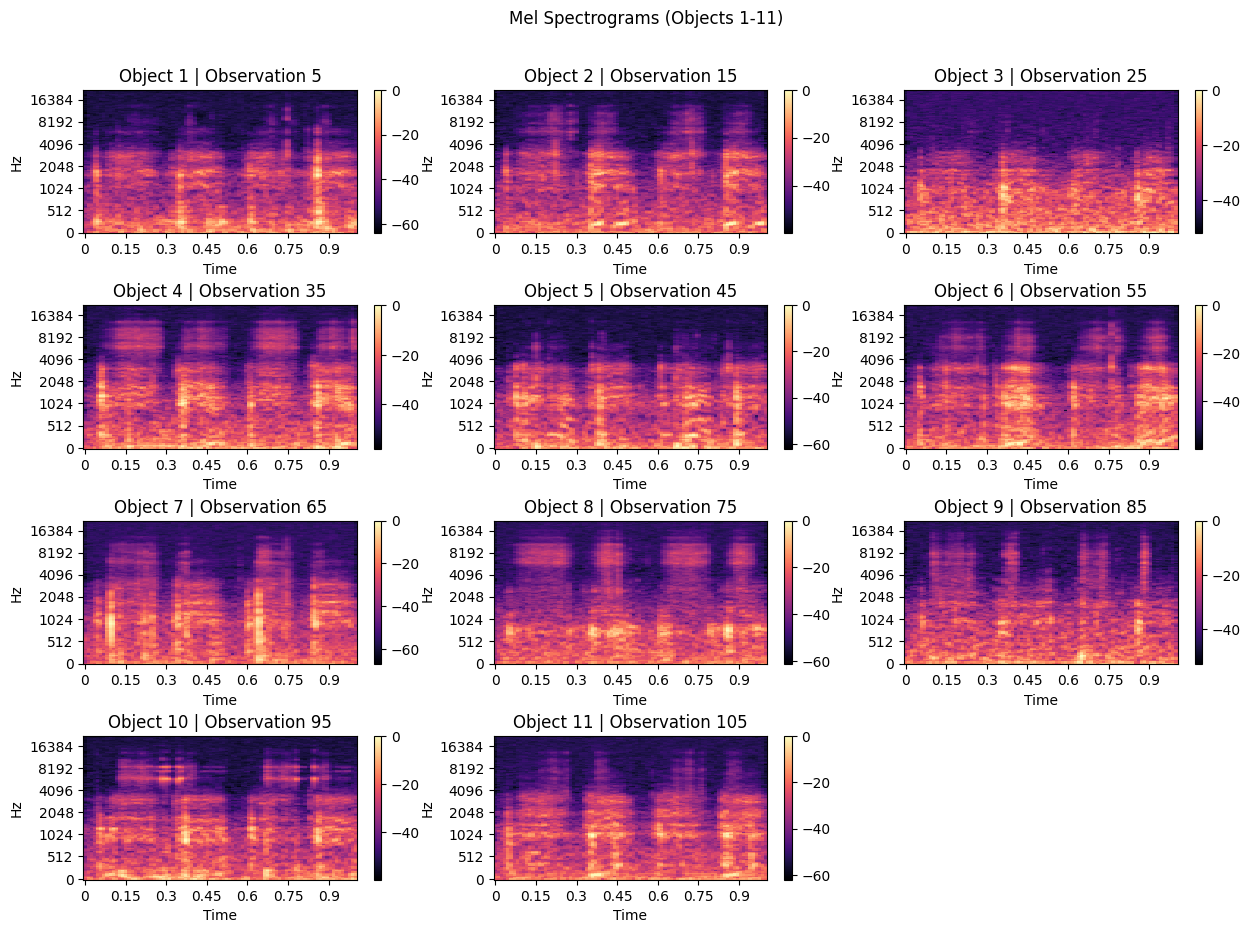

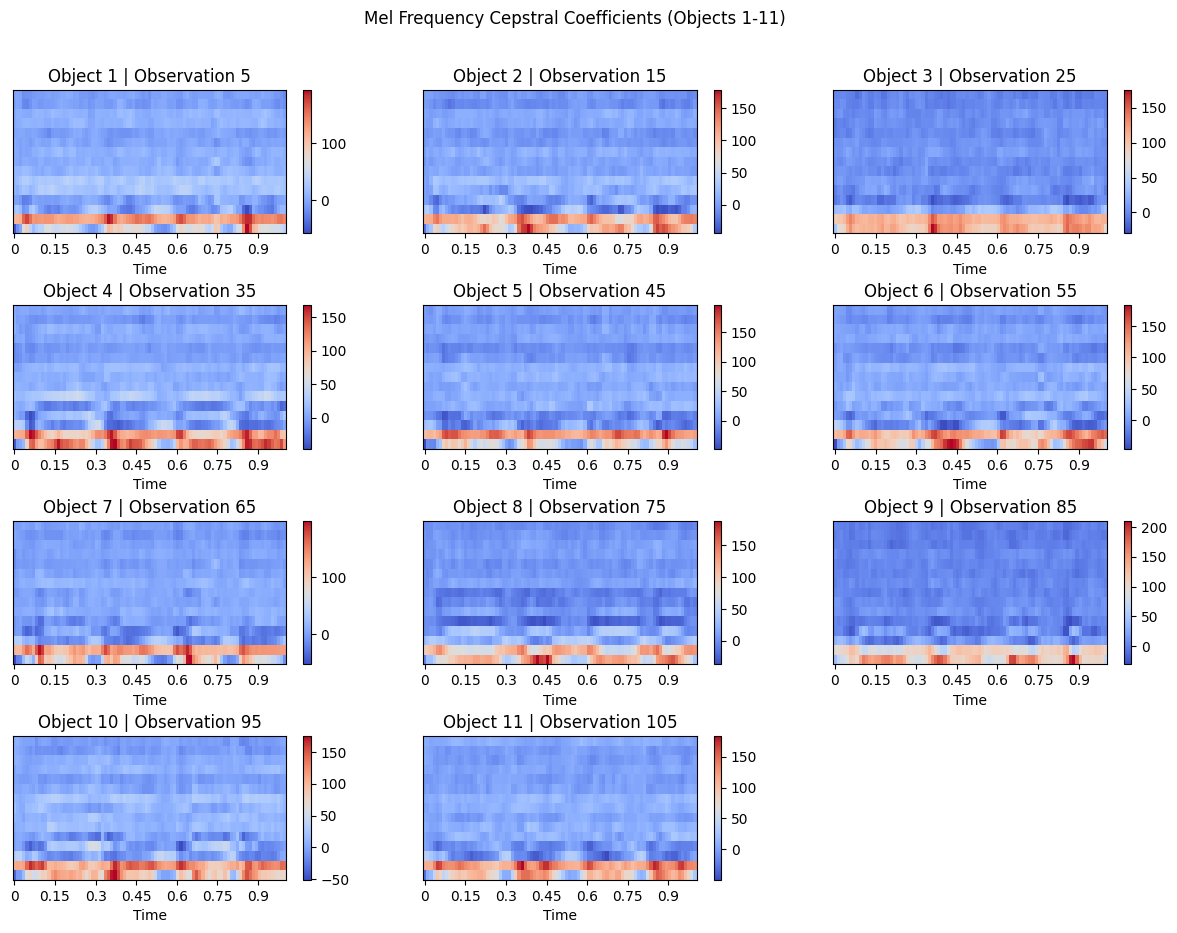

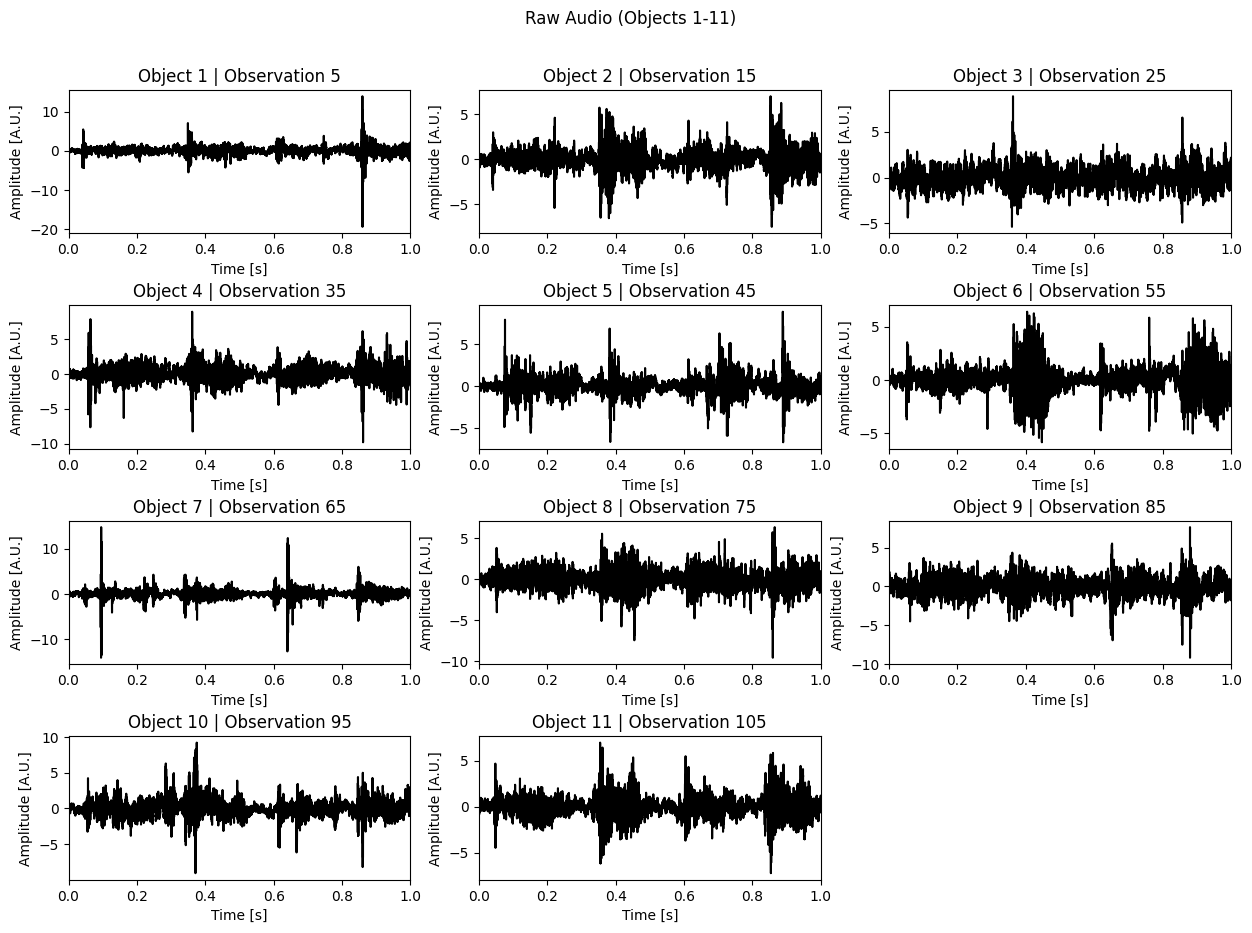

In [101]:
#extract the raw signal, MFCC components and Mel spectrograms for each object
#dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
channel = 0            #channel to read data from
objects = 11           #total number of objects in the dataset

num_rows = 4
num_cols = 3

fig_1, axes_1 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_2, axes_2 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_3, axes_3 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

fig_1.suptitle('Mel Spectrograms (Objects 1-11)')
fig_2.suptitle('Mel Frequency Cepstral Coefficients (Objects 1-11)')
fig_3.suptitle('Raw Audio (Objects 1-11)')

for object_num in range(1, min(objects, num_rows * num_cols) + 1):
    run_ideal_num = 5  #only plot the data from the first run
    run_ideal_num += 10 * (object_num - 1)
    file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
    sampling_freq, audio = audio_extraction(file_path, channel, scaling=True)

    mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
    S = librosa.feature.melspectrogram(y=audio, sr=sampling_freq, n_mels=128)

    #calculate the row and column indices for the subplot
    row = (object_num - 1) // num_cols
    col = (object_num - 1) % num_cols

    #plot Mel spectrogram
    img1 = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sampling_freq, x_axis='time', y_axis='mel', ax=axes_1[row, col])
    fig_1.colorbar(img1, ax=axes_1[row, col])
    axes_1[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the MFCC
    img2 = librosa.display.specshow(mfcc_features, sr=sampling_freq, x_axis='time', ax=axes_2[row, col])
    fig_2.colorbar(img2, ax=axes_2[row, col])
    axes_2[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the raw audio
    time = np.arange(len(audio)) / sampling_freq
    axes_3[row, col].plot(time, audio, '-k')
    axes_3[row, col].set_xlabel('Time [s]')
    axes_3[row, col].set_ylabel('Amplitude [A.U.]')
    axes_3[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')
    axes_3[row, col].set_xlim([0,1])

#remove the empty subplot
fig_1.delaxes(axes_1[-1, -1])
fig_2.delaxes(axes_2[-1, -1])
fig_3.delaxes(axes_3[-1, -1])

# Adjust layout to prevent overlapping
fig_1.subplots_adjust(hspace=0.5, top=0.9)
fig_2.subplots_adjust(hspace=0.5, top=0.9)
fig_3.subplots_adjust(hspace=0.5, top=0.9)

Upon examination of the above plots we see that there are clear visual differences in the raw data, the MFCC features and the spectrograms for each object. In particular, the MFCC features and spectrograms contain repeating elements which indicates that there are underlying hidden states that can be learned from the data. Repetitive features are not so easily identifiable in the raw vibration data. We will proceed with the use of the MFCC features to represent the frequency domain of the vibration data.

### Data Processing
Several processing steps are usually performed on time-series data. These include:
- De-noising* (e.g. using spectral noise subtraction) [(Toprak, 2017)](#dataset), [(Highes, 2014)](#skin)
- Data normalization to zero mean ($\mu = 0$) and unit standard deviation ($\sigma = 1$) [(Wang, 2022)](#regression)

*I will make use of the de-noised versions of each time-series which are included in the dataset.

We also split the dataset into training and testing data. We use a $0.70~\text{train}/0.30~\text{test}$ split for this project which is the same as the split used in the paper [(Toprak, 2017)](#dataset). The selected train/test split results in 99 observation used for training and 44 observation used for testing. We ensure that there is at least one 'real' observation in both the training and testing data.

#### References
<a id=regression></a>
Si Ao Wang, A. Albini, P. Maiolino, F. Mastrogiovanni, and G. Cannata, “Fabric Classification Using a Finger-Shaped Tactile Sensor via Robotic Sliding,” Frontiers in Neurorobotics, vol. 16, Feb. 2022, doi: https://doi.org/10.3389/fnbot.2022.808222.

<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.

<a id=skin></a>
D. Hughes and N. Correll, “A soft, amorphous skin that can sense and localize textures,” May 2014, doi: https://doi.org/10.1109/icra.2014.6907101.

In [106]:
def audio_normalization(y: np.array):
    #scale audio data to zero mean and unit standard deviation
    ys = np.zeros(y.shape)
    m = np.mean(y)
    std = np.std(y)
    ys = (y - m) / std

    return ys

In [107]:
def audio_extraction(file_path, channel, scaling=False):
    #convert .wav file to array of amplitudes
    sampling_freq, audio = wavfile.read(file_path)
    audio = np.array(audio[:, channel])
    audio = audio.astype(np.float64)

    if scaling == True:
        audio = audio_normalization(audio)

    return sampling_freq, audio

In [108]:
def mfcc_compute(default_config, sampling_freq, audio, mfcc_features, window_factor=None, padding_factor=None, hop_factor=None):
    if default_config == False:
        samples_per_run = 44100
        window_size_s = round(samples_per_run*window_factor)
        n_fft = window_size_s*padding_factor
        hop_length_s = round(window_size_s*hop_factor)
        mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)
    elif default_config == True:
        mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features)

    return mfcc_output

In [109]:
def data_extraction(channel, mfcc_features, scaling=True, window_factor=None, padding_factor=None, hop_factor=None, default_config=False):
    #function to extract training/testing data
    #dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
    
    #fixed parameters
    objects =        11                  #number of objects in dataset
    obs_ideal =      10                  #total number of ideal runs
    obs_real =       3                   #total number of real runs

    #initialize arrays
    data = {}
    lengths = {}
    
    for object_num in range(1, objects + 1):
        idx = 1
        obs_start = obs_ideal*(object_num - 1)
        for obs in range(obs_start, obs_ideal + obs_start):
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{obs}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)
            
            data[(object_num, idx)] = np.transpose(mfcc_output)
            lengths[(object_num, idx)] = np.transpose(mfcc_output).shape[0]
            idx += 1
            
        obs_start = obs_real*(object_num - 1)
        for obs in range(obs_start, obs_real + obs_start):
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{obs}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)
            
            data[(object_num, idx)] = np.transpose(mfcc_output)
            lengths[(object_num, idx)] = np.transpose(mfcc_output).shape[0]
            idx += 1   
    return data, lengths

### Creating the Hidden Markov Model
There are three key processes used to train and evaluate a HMM [(Jurafsky, 2023)](#tb):
1. Likelihood estimation: given an HMM with parameters $\lambda = \{\mathbf{A}, \mathbf{b}\}$ and an observation sequence $\mathcal{O}$, determine the likelihood $P(\mathcal{O}|\lambda)$. We solve this using what is known as the **forward algorithm**;
2. Hidden state decoding: given an observation sequence ($\mathcal{O}$) and an HMM with parameters $\lambda = \{\mathbf{A}, \mathbf{b}\}$, determine the best hidden state sequence $Q$. We solve this using the **Viterbi algorithm**;
3. Learning model parameters: given an observation sequence ($\mathcal{O}$) and the set of possible states in the HMM ($\mathcal{S}$), determine the HMM parameters $\lambda = \{\mathbf{A}, \mathbf{b}\}$. We solve this using the **forward-backward algorithm**.

We leverage the $\texttt{hmmlearn}$ ([source code](https://github.com/hmmlearn/hmmlearn)) library to create a HMM. $\texttt{hmmlearn}$ has three main functions: 
- $\texttt{fit}(~)$: used to train the HMM
- $\texttt{predict}(~)$: used to predict the sequence of hidden states for a given sequence (not used here)
- $\texttt{score}(~)$: used to evaluate the likelihood of a given observation given the model. 

The structure of an HMM is shown in **Fig. 2**. A HMM is trained for every object in the dataset yielding 11 models ($\lambda_k \in \boldsymbol{\lambda}, k \in [1,2,\dots,11]$) where each model is defined by a transition matrix and emission probabilities ($\lambda_k = \{\mathbf{A}_k, \mathbf{b}_k\}$). Each model is trained on a concatenated array of observation sequences for the given object. We pre-select the maximum possible number of hidden states and assume that this number is the same for all object models. To make a prediction we feed a test observation ($\mathcal{O}_{\text{test}}$) through each model and extract the predictions ($P(\mathcal{O}_{\text{test}}|\lambda_k)$). The class ($c_{\text{test}}$) of the object is then selected as $\max P(\mathcal{O}_{\text{test}}|\lambda_k), k = [1,2,\dots,11]$.

![fig_2](../tikz_figures/hmm_3.png)
**Figure 2**: Illustration of the Hidden Markov Model-based algorithm used for classification.

#### References
<a id=tb></a>
D. Jurafsky and J. Martin, Speech and Language Processing, 3rd ed. 2023.

In [110]:
class hmm_generation(object):
  def __init__(self, model_name='GaussianHMM', hidden_states=4, cov_type='diag', start_state=None, n_iter=1000):
    #model structure adapted from (1) https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4 
    #                             (2) https://maharshi-yeluri.medium.com/understanding-and-implementing-speech-recognition-using-hmm-6a4e7666de1 
    self.model_name = model_name
    self.n_components = hidden_states
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.start_state = start_state
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'GMMHMM':
      self.model = hmm.GMMHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'MultinomialHMM':
      self.model = hmm.MultinomialHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    elif self.model_name == 'PoissonHMM':
      self.model = hmm.PoissonHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

  def train(self, training_data, lengths):
    np.seterr(all='ignore')
    self.model.fit(training_data, lengths)
    return self.model.monitor_.converged

  def observation_likelihood(self, observation_sequence, lengths=None):
    return self.model.score(observation_sequence, lengths=lengths)

  def transition_matrix(self):
    return self.model.transmat_

In [21]:
def split_data(data, lengths, split):
    #fixed parameters
    objects = 11
    total_obs = 13

    #compute the numbers of training/testing observations
    train_obs = round(total_obs*split)
    
    #randomly select observations for training/testing
    nums = list(range(1, total_obs + 1))
    random.shuffle(nums)
    train_nums = nums[:train_obs]
    test_nums = nums[train_obs:]

    print(train_nums)
    print(test_nums)

    train_data = {}
    test_data = {}

    train_lengths = {}
    test_lengths = {}

    for object_num in range(1, objects + 1):
        train_data[object_num] = []
        train_lengths[object_num] = []
        test_data[object_num] = []
        test_lengths[object_num] = []
        for obs in train_nums:
            train_data[object_num].append(data[(object_num, obs)])
            train_lengths[object_num].append(lengths[(object_num, obs)])
        for obs in test_nums:
            test_data[object_num].append(data[(object_num, obs)])
            test_lengths[object_num].append(lengths[(object_num, obs)])

    return train_data, test_data, train_lengths, test_lengths

def concatenate_data(data):
    #fixed parameters
    objects = 11
    
    data_concatenate = {}
    for object_num in range(1, objects + 1):
        data_concatenate[object_num] = []
        for obs_sequence in data[object_num]:
            for value in obs_sequence:
                data_concatenate[object_num].append(value)
    
    return data_concatenate
        


In [115]:
def model_training(hidden_states, model_name, cov_type, start_state, train_data, train_lengths):
    #train the model using the training dataset
    objects = 11

    trained_models = {}
    trained_model = None
    conv_bool_set = []
    transition_matrices = {}

    for object_num in range(1, objects + 1):
        trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, start_state=start_state)
        conv_bool = trained_model.train(training_data=train_data[object_num], lengths=train_lengths[object_num])
        if conv_bool == True:
            conv_bool_set.append('True')
        else:
            conv_bool_set.append('False')
        
        transition_matrices[object_num] = trained_model.transition_matrix()
        trained_models[object_num] = trained_model
        trained_model = None
        
    
    return trained_models, conv_bool_set, transition_matrices

In [173]:
def model_testing(trained_models, data):
    #estimate the label of each time-series in the testing dataset
    #fixed parameters
    objects = 11
    
    #initialize arrays
    predicted_labels = []
    real_labels = []

    for object_num in range(1, objects + 1):
        for obs_sequence in data[object_num]:
            for object_num_sub in range(1, objects + 1):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if object_num_sub == 1:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub

            real_labels.append(f'Obj. {object_num}')
            predicted_labels.append(f'Obj. {highest_likelihood_object}')
    
    return real_labels, predicted_labels

In [24]:
def model_accuracy(real_labels, predicted_labels):
    accuracy = accuracy_score(real_labels, predicted_labels)
    
    return accuracy

In [25]:
def print_convergence(conv_bool_set):
    for idx, value in enumerate(conv_bool_set):
        print(f'Object {idx + 1: <2}: {value: <2}| ', end="")
    print('\n')

In [26]:
def plot_confusion_matrix(ax, cm, classes, title, normalize=False):
    #function to generate confusion matrices
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cmap = plt.cm.Reds

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

### Overview of Experiments + Discussion
We will now perform a series of experiments aimed at understanding the behavior of the HMM and to determine an 'optimal' set of parameters. Each experiment will consist of the cells containing code used to generate and plot the results followed by a brief analysis and discussion of the data.

### Varying the Number of Hidden States
In the first experiment we will analyze the effect of changing the number of possible hidden states in the HMM. We will do this by creating a training/testing dataset and evaluating the accuracy of HMMs with different numbers of allowable hidden states.

In [226]:
#analyze the effect of changing the number of hidden states
#define data extraction parameters
channel = 0
scaling = True

#define train/test split
total_obs = 13
split = 0.7

#model parameters
model_name = 'GaussianHMM'
cov_type = 'diag'
mfcc_features = 15
start_state = 1
hidden_states_max = round(total_obs*split)
hidden_states_set = [i for i in range(1,hidden_states_max+1)]

#initialize arrays
accuracies_train = []
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = []
real_labels_all_test = {}
predicted_labels_all_test = {}
#------------------------------
transition_matrices_all = {}

#extract data
data, lengths = data_extraction(channel=channel,
                                mfcc_features=mfcc_features, 
                                default_config=True,                                                        
                                scaling=scaling) 

train_data, test_data, train_lengths, test_lengths = split_data(data, lengths, split)
train_data_concatenated = concatenate_data(train_data)                                                             

for hidden_states in hidden_states_set:
    trained_models, conv_bool_set, transition_matrices = model_training(hidden_states=hidden_states,
                                                                        model_name=model_name,
                                                                        cov_type=cov_type,
                                                                        start_state=start_state,
                                                                        train_data=train_data_concatenated,
                                                                        train_lengths=train_lengths)

    transition_matrices_all[hidden_states] = transition_matrices                                       
    
    real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                              data=train_data)
    
    real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                            data=test_data)
    
    print(f'Number of Hidden States: {hidden_states}')
    print_convergence(conv_bool_set)
    
    accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
    accuracies_test.append(accuracy_test)
    real_labels_all_test[hidden_states] = real_labels_test
    predicted_labels_all_test[hidden_states] = predicted_labels_test

    accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
    accuracies_train.append(accuracy_train)
    real_labels_all_train[hidden_states] = real_labels_train
    predicted_labels_all_train[hidden_states] = predicted_labels_train

[10, 13, 5, 3, 6, 11, 2, 7, 8]
[4, 1, 12, 9]
Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : Tr

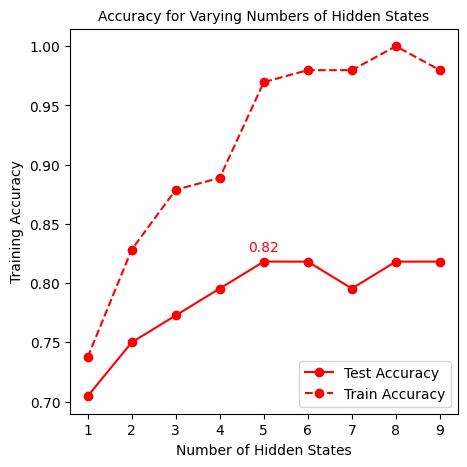

In [227]:
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes.set_title("Accuracy for Varying Numbers of Hidden States", fontsize=10)
axes.plot(hidden_states_set, accuracies_test, "-o", color='red', label='Test Accuracy')
axes.plot(hidden_states_set, accuracies_train, "--o", color='red', label='Train Accuracy')
max_test = max(accuracies_test)
max_idx_test = accuracies_test.index(max_test)
axes.annotate(f'{max_test:.2f}', xy=(hidden_states_set[max_idx_test], max_test),
              xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', color='red')

axes.set_xticks(hidden_states_set)
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Training Accuracy")
axes.legend(loc='lower right')
plt.show()

The previous cells show the accuracy of the classification tasks for different values of the number of hidden states. The training accuracy steadily increases as the number of hidden states increases. The testing accuracy is highest for five hidden states. The lowest testing accuracy is observed for one hidden state. A HMM with a single hidden state corresponds to a transition matrix with a single element ($\mathbf{A} = 1$) and emission densities capturing the probability of a given observation. In the remaining experiment we will **not** fix the number of hidden states, since it is likely that the 'optimal' number of hidden states will depend on other parameters in the HMM. Next, we plot the confusion matrices for the testing data.

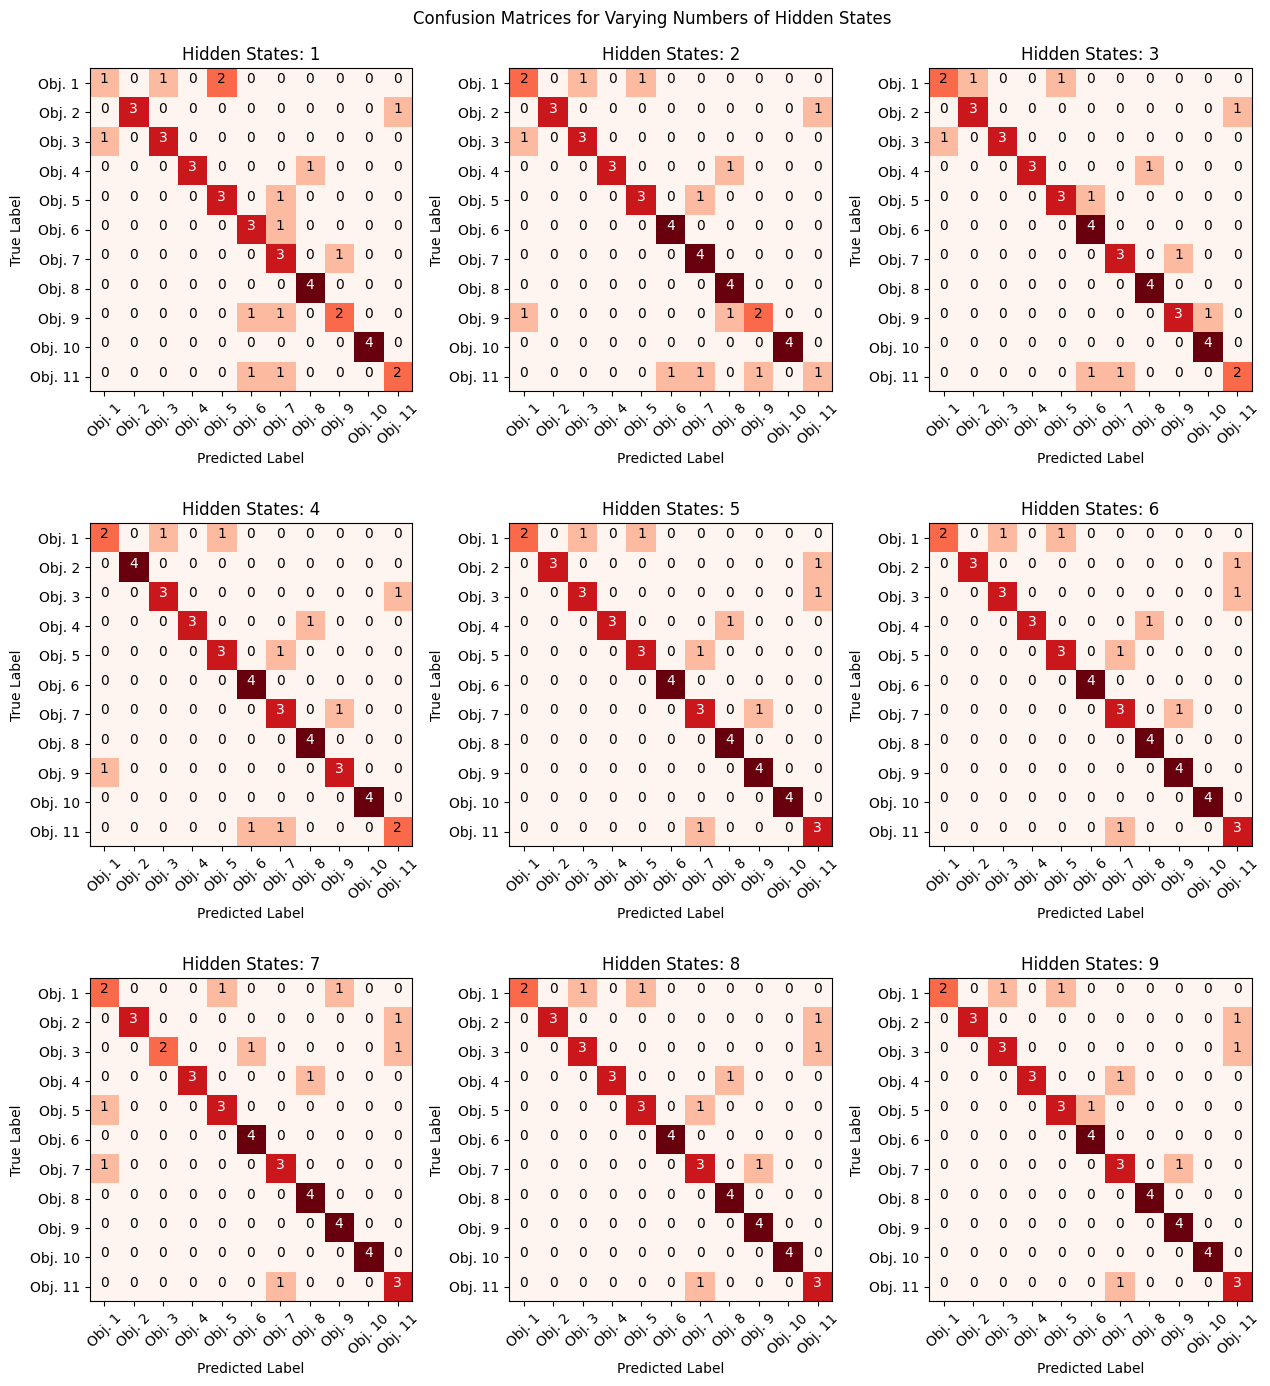

In [228]:
#generate confusion matrices
objects = 11
object_set = [i for i in range(1, objects + 1)]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.suptitle('Confusion Matrices for Varying Numbers of Hidden States')
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[hidden_states], predicted_labels_all_test[hidden_states],labels=classes)
    title = f'Hidden States: {hidden_states}'
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, title=title, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

Analyzing the confusion matrices above, we note the the high number of misclassifications for object 5 (corn on the cob). This is unexpected since the corn has a distinct texture compared to the other objects in the dataset. Next we plot the transition probability matrices.

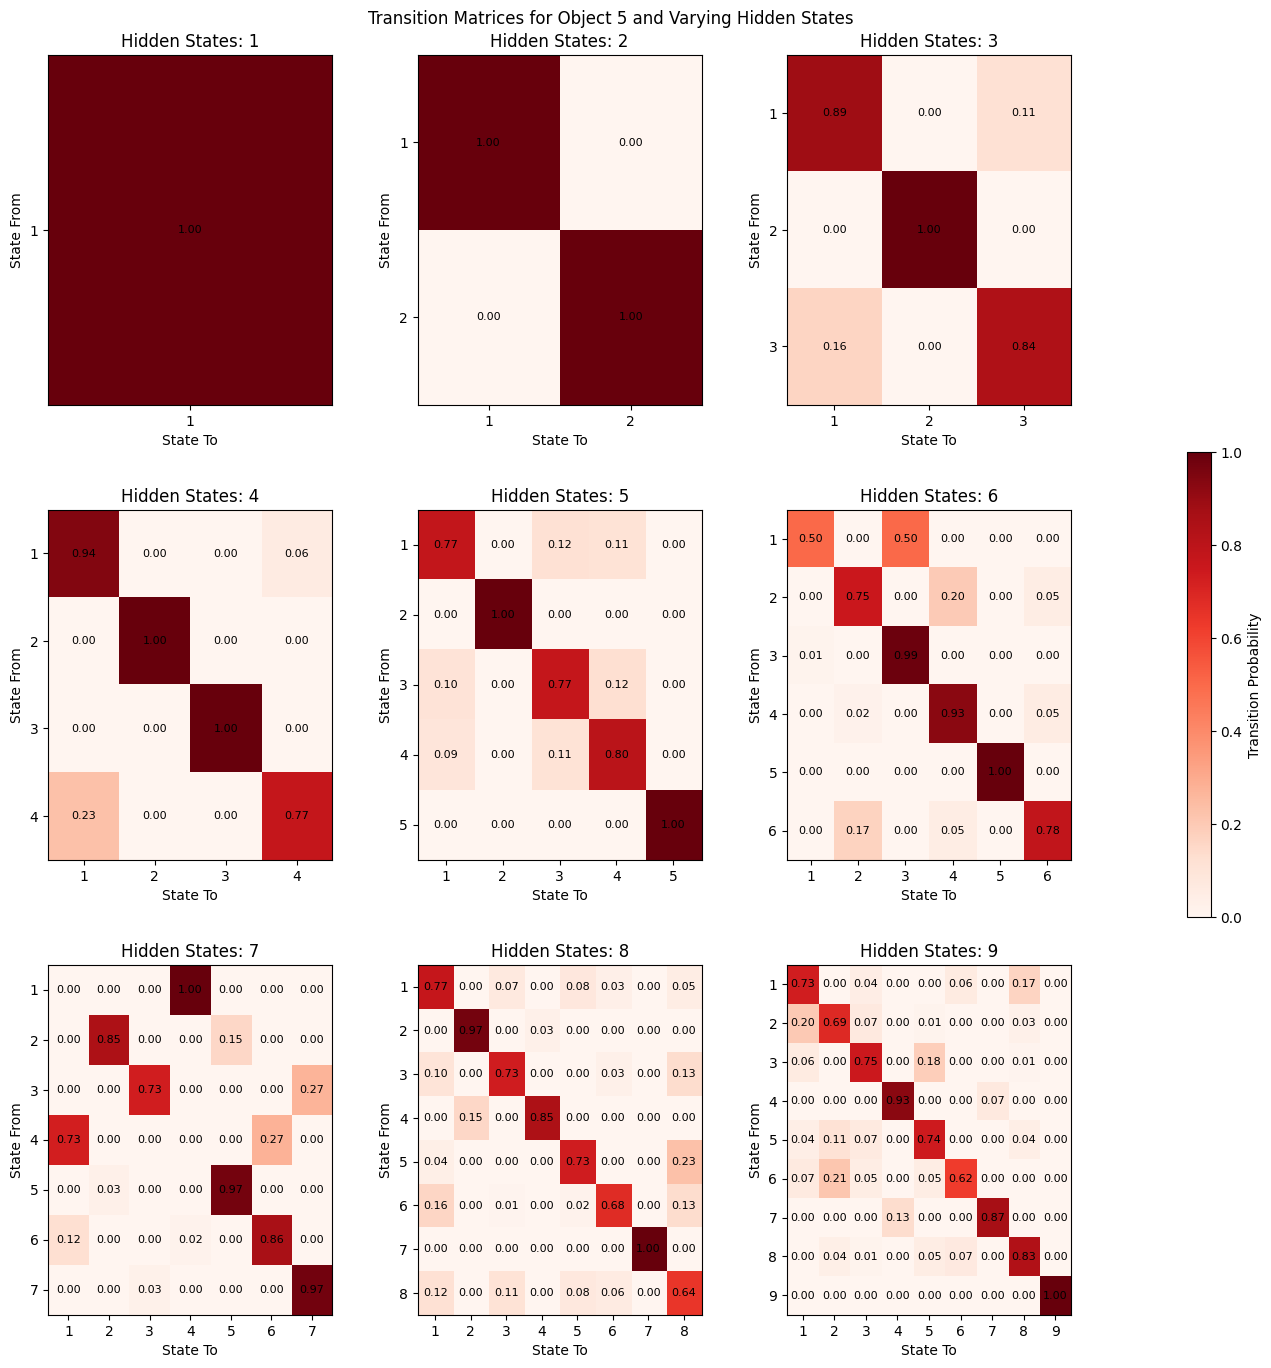

In [229]:
#plot the transition matrices for different hidden states values
#choose object 8 which is classified perfectly for all hidden states
object_to_plot = 5
num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

cbar_min = min(np.min(matrix) for matrices in transition_matrices_all.values() for matrix in matrices.values())
cbar_max = max(np.max(matrix) for matrices in transition_matrices_all.values() for matrix in matrices.values())

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.suptitle(f'Transition Matrices for Object {object_to_plot} and Varying Hidden States')
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    matrix = transition_matrices_all[hidden_states][object_to_plot]
    im = axes[row_idx, col_idx].imshow(matrix, aspect='auto', cmap='Reds', vmin=cbar_min, vmax=cbar_max)
    axes[row_idx, col_idx].set_title(f'Hidden States: {hidden_states}')
    axes[row_idx, col_idx].set_xlabel('State To')
    axes[row_idx, col_idx].set_ylabel('State From')

    # Set ticks in the middle of the boxes
    axes[row_idx, col_idx].set_xticks(np.arange(len(matrix)))
    axes[row_idx, col_idx].set_yticks(np.arange(len(matrix)))

    # Set tick labels
    axes[row_idx, col_idx].set_xticklabels(np.arange(1, len(matrix) + 1))
    axes[row_idx, col_idx].set_yticklabels(np.arange(1, len(matrix) + 1))

    # Add cell values
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            axes[row_idx, col_idx].text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

# Add a common colorbar
cbar = fig.colorbar(im, ax=axes.ravel(), orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Transition Probability') 

# Show the plots
plt.show()

The plots above show the transition probability matrices for different numbers of hidden states and for object five. It is interesting to see that the off-diagonal terms become more pronounced as the number of hidden states increases. This indicates that a higher number of hidden states are capturing transitions between hidden states rather than maintaining the current hidden state.

### Effect of Starting Seed on Model Accuracy
As mentioned [here](https://stackoverflow.com/questions/39930895/why-i-get-different-values-everytime-i-run-the-function-hmmlearn-hmm-gaussianhmm), the expectation-maximization algorithm used by $\texttt{hmmlearn}$ may get trapped in local maxima. Therefore, we expect different model training runs to result in different predictions. Furthermore, the transition probabilities and emission densities predicted in training may depend on the starting seed which may affect the initialization of the model parameters. In the next cells, we will show the effect of changing the starting seed on the training/testing accuracy. Note that we will be using the same training and testing data as the last set of experiments for consistency.

In [230]:
#analyze the effect of changing the starting seed
#model parameters
model_name = 'GaussianHMM'
cov_type = 'diag'
start_state_set = [i for i in range(0, 30)]

#initialize arrays
accuracies_train = {}
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = {}
real_labels_all_test = {}
predicted_labels_all_test = {}

for start_state in start_state_set:
    print(f'Starting Seed: {start_state}')
    accuracies_test[start_state] = []
    accuracies_train[start_state] = []
    for hidden_states in hidden_states_set:
        trained_models, conv_bool_set, _ = model_training(hidden_states=hidden_states,
                                                          model_name=model_name,
                                                          cov_type=cov_type,
                                                          start_state=start_state,
                                                          train_data=train_data_concatenated,
                                                          train_lengths=train_lengths)
    
        real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                                  data=train_data)
    
        real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                                data=test_data)
        
        print(f'Number of Hidden States: {hidden_states}')
        print_convergence(conv_bool_set)
        
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracies_test[start_state].append(accuracy_test)
        real_labels_all_test[(start_state, hidden_states)] = real_labels_test
        predicted_labels_all_test[(start_state, hidden_states)] = predicted_labels_test

        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        accuracies_train[start_state].append(accuracy_train)
        real_labels_all_train[(start_state, hidden_states)] = real_labels_train
        predicted_labels_all_train[(start_state, hidden_states)] = predicted_labels_train

        

Starting Seed: 0
Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 

In [231]:
#compute average accuracy for each value of the number of hidden states across all starting seeds
average_accuracies_test = []
std_accuracies_test = []
#---------------------------
average_accuracies_train = []
std_accuracies_train = []

for hidx, hidden_states in enumerate(hidden_states_set):
    avg = 0
    std_array = []
    for start_state in start_state_set:
        avg += accuracies_test[start_state][hidx]
        std_array.append(accuracies_test[start_state][hidx])
    std_accuracies_test.append(statistics.stdev(std_array))
    average_accuracies_test.append(avg/len(start_state_set))

for hidx, hidden_states in enumerate(hidden_states_set):
    avg = 0
    std_array = []
    for start_state in start_state_set:
        avg += accuracies_train[start_state][hidx]
        std_array.append(accuracies_train[start_state][hidx])
    std_accuracies_train.append(statistics.stdev(std_array))
    average_accuracies_train.append(avg/len(start_state_set))

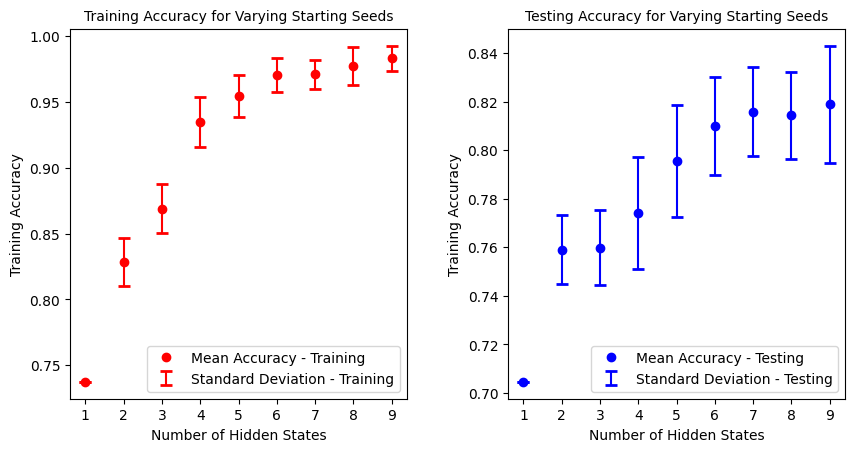

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes[0].set_title("Training Accuracy for Varying Starting Seeds", fontsize=10)
axes[1].set_title("Testing Accuracy for Varying Starting Seeds", fontsize=10)

axes[0].plot(hidden_states_set, average_accuracies_train, 'o', color='red', alpha=1, label='Mean Accuracy - Training')
axes[0].errorbar(hidden_states_set, average_accuracies_train, yerr=std_accuracies_train, fmt='none', ecolor='red', capsize=4, capthick=2, label='Standard Deviation - Training')

axes[1].plot(hidden_states_set, average_accuracies_test, 'o', color='blue', alpha=1, label='Mean Accuracy - Testing')
axes[1].errorbar(hidden_states_set, average_accuracies_test, yerr=std_accuracies_test, fmt='none', ecolor='blue', capsize=4, capthick=2, label='Standard Deviation - Testing')

axes[0].set_xticks(hidden_states_set)
axes[0].set_xlabel("Number of Hidden States")
axes[0].set_ylabel("Training Accuracy")
axes[0].legend()

axes[1].set_xticks(hidden_states_set)
axes[1].set_xlabel("Number of Hidden States")
axes[1].set_ylabel("Training Accuracy")
axes[1].legend()
plt.show()

In [233]:
print(f'Standard Deviations, Train: {std_accuracies_train}')
print(f'Standard Deviations, Test: {std_accuracies_test}')

print(f'Standard Deviation MAX, Train: {max(std_accuracies_train)}')
print(f'Standard Deviation MAX, Test: {max(std_accuracies_test)}')

Standard Deviations, Train: [0.0, 0.01818568788882844, 0.018470431428401015, 0.018884843457170994, 0.015860571327102016, 0.01297724186851722, 0.011170586941874163, 0.01445230568301515, 0.009686127302735045]
Standard Deviations, Test: [0.0, 0.014123987869678745, 0.015429785316462776, 0.02306437560931476, 0.023115801259800374, 0.020225408787823296, 0.01825026302039181, 0.01798812713356634, 0.024231809327041366]
Standard Deviation MAX, Train: 0.018884843457170994
Standard Deviation MAX, Test: 0.024231809327041366


The above cells show the mean and standard deviations for the model accuracy on both the training and testing datasets. We clearly see that other than for $\texttt{hidden\_states} = 1$, changing the starting seed value produces accuracy variations in range of $\pm 0.025$ for testing and $\pm 0.019$ (using standard deviation to quantify variations). For the remaining experiments, I will fix the starting seed.

### Modifying the Covariance Type

The $\texttt{GaussianHMM}$ model in $\texttt{hmmlearn}$ assumes that for each hidden state ($s \in \mathcal{S}$), the observation ($o \in \mathcal{O}$) are generated from multivariate Gaussian distributions [(Natsume, 2022)](#mblog). Each multivariate Gaussian distribution is defined by a multivariate mean and covariance matrix [(Natsume, 2022)](#mblog). $\texttt{hmmlearn}$ allows the user to define the restrictions placed on the covariance matrices by defining different covariance types ($\texttt{cov\_type}$) [(Natsume, 2022)](#mblog):

1. $\texttt{cov\_type} = \texttt{"diag"}$: the covariance matrix for each hidden state only contains diagonal terms;
2. $\texttt{cov\_type} = \texttt{"spherical"}$: the covariance matrix for each hidden state is of the form ($\mathbf{C} = \lambda \mathbf{I}$)
3. $\texttt{cov\_type} = \texttt{"full"}$: no restrictions are placed on the covariance matrices
4. $\texttt{cov\_type} = \texttt{"tied"}$: all hidden states share the same matrix however, no no restrictions are placed on the covariance matrix

In the next cells, I will determine which covariance type yields the highest accuracy. Once again, I will used the same testing and training data for consistency. I will also perform the next set of experiments for all the hidden states previously studied. This will allow us to determine if there is a correlation between the covariance type and the number of hidden states.

#### References
<a id=mblog></a>
Y. Natsume. (2022, April 25). Hidden Markov Models with Python: Modelling Sequential Data Stochastically. https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7.

In [234]:
#analyze the effect of changing the model type and the covariance type
#model parameters
model_name_set = 'GaussianHMM'
cov_type_set = ['diag','spherical','full','tied']
start_state = 1

#initialize arrays
accuracies_test = {}
real_labels_all_test = {}
predicted_labels_all_test = {}
#------------------------
accuracies_train = {}
real_labels_all_train = {}
predicted_labels_all_train = {}

for cov_type in cov_type_set:
    print(f'Covariance Matrix Type: {cov_type}')
    accuracies_test[cov_type] = []
    accuracies_train[cov_type] = []
    for hidden_states in hidden_states_set:
        trained_models, conv_bool_set, _ = model_training(hidden_states=hidden_states,
                                                          model_name=model_name,
                                                          cov_type=cov_type,
                                                          start_state=start_state,
                                                          train_data=train_data_concatenated,
                                                          train_lengths=train_lengths)
    
        real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                                  data=train_data)
    
        real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                                data=test_data)
        
        print(f'Number of Hidden States: {hidden_states}')
        print_convergence(conv_bool_set)
        
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracies_test[cov_type].append(accuracy_test)
        real_labels_all_test[(cov_type, hidden_states)] = real_labels_test
        predicted_labels_all_test[(cov_type, hidden_states)] = predicted_labels_test

        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        accuracies_train[cov_type].append(accuracy_train)
        real_labels_all_train[(cov_type, hidden_states)] = real_labels_train
        predicted_labels_all_train[(cov_type, hidden_states)] = predicted_labels_train

Covariance Matrix Type: diag
Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : T

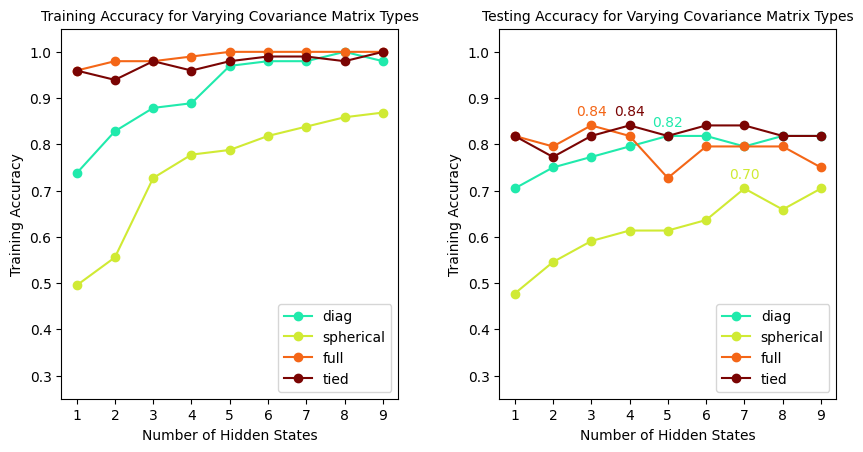

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
colormap = plt.colormaps['turbo']
color_offset = 0.35

axes[0].set_title("Training Accuracy for Varying Covariance Matrix Types", fontsize=10)
axes[1].set_title("Testing Accuracy for Varying Covariance Matrix Types", fontsize=10)

for cidx, cov_type in enumerate(cov_type_set):
    color_value = (cidx / (len(cov_type_set) - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)
    axes[0].plot(hidden_states_set, accuracies_train[cov_type], "-o", color=color, label=cov_type)

for cidx, cov_type in enumerate(cov_type_set):
    color_value = (cidx / (len(cov_type_set) - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)
    axes[1].plot(hidden_states_set, accuracies_test[cov_type], "-o", color=color, label=cov_type)
    max_test = max(accuracies_test[cov_type])
    max_idx_test = accuracies_test[cov_type].index(max_test)
    axes[1].annotate(f'{max_test:.2f}', xy=(hidden_states_set[max_idx_test], max_test),
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', color=color)

axes[0].set_xticks(hidden_states_set)
axes[1].set_xticks(hidden_states_set)

axes[0].set_ylim(ymin=0.25, ymax= 1.05)
axes[1].set_ylim(ymin=0.25, ymax = 1.05)

axes[0].set_xlabel("Number of Hidden States")
axes[0].set_ylabel("Training Accuracy")
axes[1].set_xlabel("Number of Hidden States")
axes[1].set_ylabel("Training Accuracy")

axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')

plt.show()

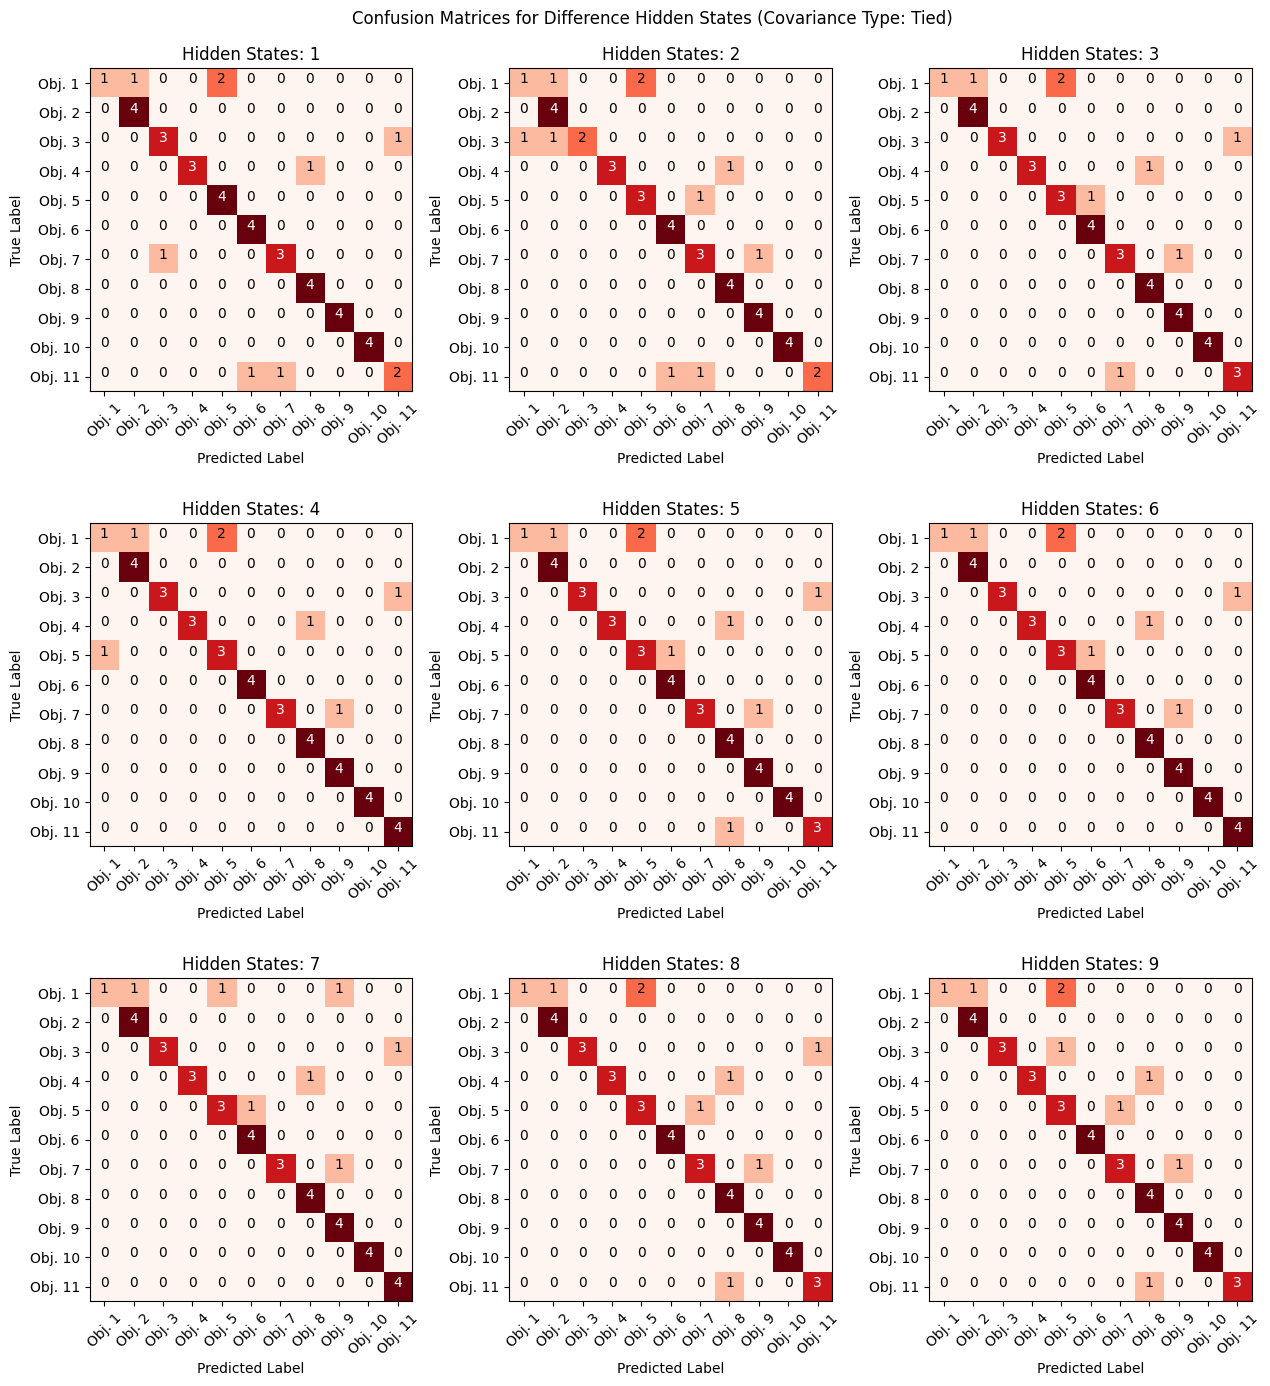

In [236]:
#generate the confusion matrices
objects = 11
cov_type = 'tied'
object_set = [i for i in range(1, objects + 1)]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)
fig.suptitle('Confusion Matrices for Difference Hidden States (Covariance Type: Tied)')

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[(cov_type, hidden_states)], predicted_labels_all_test[(cov_type, hidden_states)], labels=classes)
    title=f'Hidden States: {hidden_states}'
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, title=title, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

The experiments indicate that the accuracy of $\texttt{cov\_type} = {\texttt{tied}}$ is the most consistent; it results in the highest accuracy for $7/9$ hidden states. $\texttt{cov\_type} = {\texttt{spherical}}$ consistently has the worst accuracy. $\texttt{cov\_type} = {\texttt{diag}}$ should be considered as an option if computational efficiency is prioritized since it suffices to compute the diagonal terms of the covariance matrix. For the remaining experiments, we will used $\texttt{cov\_type} = {\texttt{tied}}$, since it appears to give stable accuracies across all hidden states, allowing us to continue to experiment with the number of hidden states as a parameter.

### Textural Uniqueness
As previously mentioned, here are multiple object pairs in the dataset with the same texture but different colors. Since a purely acoustic-based classifier can not distinguish between colors, it is unlikely that it can correctly classify these object pairs. We will now modify the $\texttt{data\_extraction}(~)$ function to explicitly account for textural uniqueness. In other words, we consider objects with the same textures as being part of the same class. Specifically, the following objects will be considered as part of the same textural classes:

| Objects | Description |
| :---: | :---: |
| 1, 3 | Foam Balls |
| 2, 11 | Mesh Loofahs |
| 9, 11 | Foam Block and Sphere |

In [152]:
def model_testing_new(trained_models, data):
    #estimate the label of each time-series in the testing dataset
    #fixed parameters
    objects = 11
    
    #initialize arrays
    predicted_labels = []
    real_labels = []

    for object_num in range(1, objects + 1):
        for obs_sequence in data[object_num]:
            for object_num_sub in range(1, objects + 1):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if object_num_sub == 1:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub

            if object_num == 3:
                object_num_corr = 1
            elif object_num == 11:
                object_num_corr = 2
            elif object_num == 8:
                object_num_corr = 4
            elif object_num == 10:
                object_num_corr = 9
            else:
                object_num_corr = object_num
                
            if highest_likelihood_object == 3:
                highest_likelihood_object_corr = 1
            elif highest_likelihood_object == 11:
                highest_likelihood_object_corr = 2
            elif highest_likelihood_object == 8:
                highest_likelihood_object_corr = 4
            elif highest_likelihood_object == 10:
                highest_likelihood_object_corr = 9
            else:
                highest_likelihood_object_corr = highest_likelihood_object

            real_labels.append(f'Obj. {object_num_corr}')
            predicted_labels.append(f'Obj. {highest_likelihood_object_corr}')
    
    return real_labels, predicted_labels

In [237]:
#analyze the affect of accounting for textural uniqueness
#model parameters
model_name = 'GaussianHMM'
cov_type = 'tied'
start_state = 1

#initialize arrays
accuracies_train_new = []
real_labels_all_train_new = {}
predicted_labels_all_train_new = {}
#------------------------------
accuracies_test_new = []
real_labels_all_test_new = {}
predicted_labels_all_test_new = {}

for hidden_states in hidden_states_set:
    trained_models, conv_bool_set, _ = model_training(hidden_states=hidden_states,
                                                      model_name=model_name,
                                                      cov_type=cov_type,
                                                      start_state=start_state,
                                                      train_data=train_data_concatenated,
                                                      train_lengths=train_lengths)
    
    real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                  data=train_data)
    
    real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                data=test_data)
    
    print(f'Number of Hidden States: {hidden_states}')
    print_convergence(conv_bool_set)
    
    accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
    accuracies_test_new.append(accuracy_test)
    real_labels_all_test_new[hidden_states] = real_labels_test
    predicted_labels_all_test_new[hidden_states] = predicted_labels_test

    accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
    accuracies_train_new.append(accuracy_train)
    real_labels_all_train_new[hidden_states] = real_labels_train
    predicted_labels_all_train_new[hidden_states] = predicted_labels_train

Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 

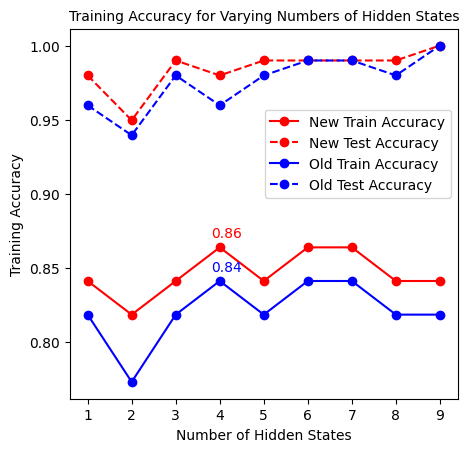

In [238]:
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes.set_title("Training Accuracy for Varying Numbers of Hidden States", fontsize=10)
axes.plot(hidden_states_set, accuracies_test_new, "-o", color='red', label='New Train Accuracy')
axes.plot(hidden_states_set, accuracies_train_new, "--o", color='red', label='New Test Accuracy')
axes.plot(hidden_states_set, accuracies_test[cov_type], "-o", color='blue', label='Old Train Accuracy')
axes.plot(hidden_states_set, accuracies_train[cov_type], "--o", color='blue', label='Old Test Accuracy')

max_test_old = max(accuracies_test[cov_type])
max_test_new = max(accuracies_test_new)

max_idx_test_old = accuracies_test[cov_type].index(max_test_old)
max_idx_test_new = accuracies_test_new.index(max_test_new)

axes.annotate(f'{max_test_old:.2f}', xy=(hidden_states_set[max_idx_test_old], max_test_old),
              xytext=(5, 5), textcoords='offset points', ha='center', va='bottom', color='blue')
axes.annotate(f'{max_test_new:.2f}', xy=(hidden_states_set[max_idx_test_new], max_test_new),
              xytext=(5, 5), textcoords='offset points', ha='center', va='bottom', color='red')


axes.set_xticks(hidden_states_set)
axes.legend(loc='upper right', bbox_to_anchor=(1, 0.8))
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Training Accuracy")

plt.show()

As expected, accounting for textural uniqueness increases the accuracy of the classifier. In the remaining, textural uniqueness will be taken into account.

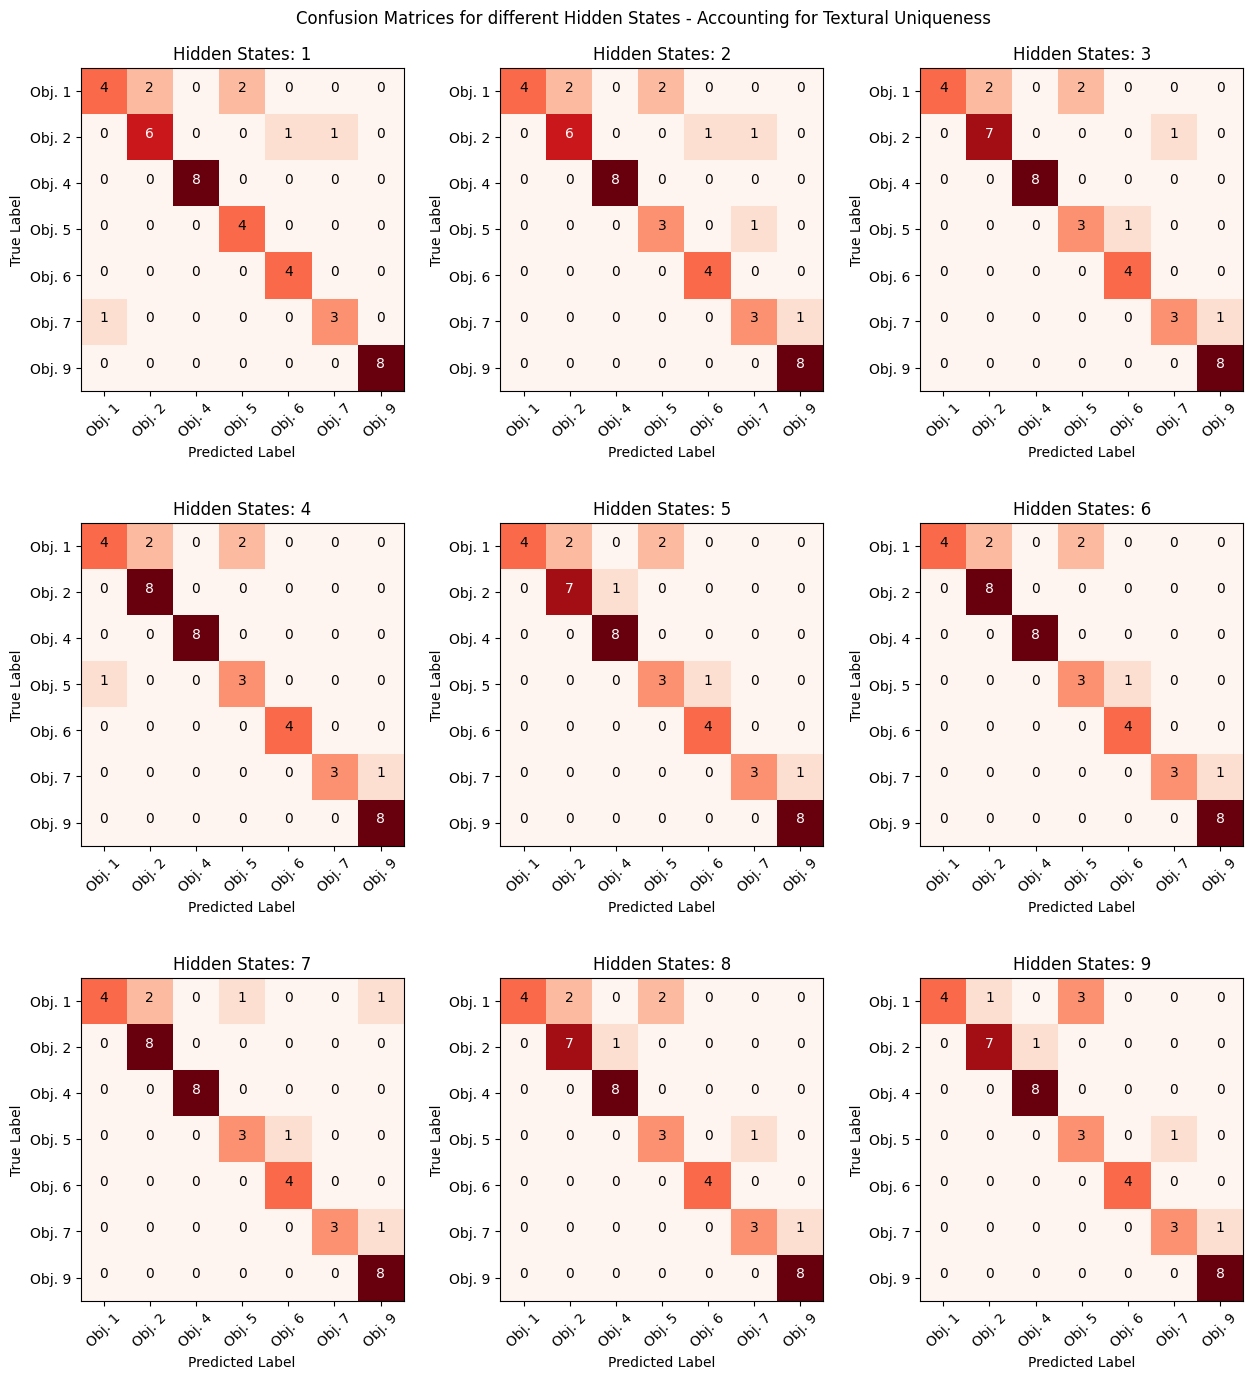

In [239]:
#generate the confusion matrices
objects = 11
cov_type = 'tied'
object_set = [1,2,4,5,6,7,9]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)
fig.suptitle('Confusion Matrices for different Hidden States - Accounting for Textural Uniqueness')

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test_new[hidden_states], predicted_labels_all_test_new[hidden_states], labels=classes)
    title = f'Hidden States: {hidden_states}'
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, title=title, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

Observing the confusion matrices above, we again note that taking textural uniqueness into account increases the accuracy of the classifier (results in fewer misclassifications).

### Further Optimization of the Algorithm
Two features of the algorithm that we have not experimented with are the number of MFCC components and the parameters used to compute the Fourier Transform:
1. $\texttt{window\_factor}$: size of the sliding window, defined as the fraction of the full signal
2. $\texttt{padding\_factor}$: the amount of padding adding to windowed data before computing the Fourier Transform, defined as a multiplier in powers of two
3. $\texttt{hop\_factor}$: the amount of overlap between windows, defined as a fraction of the window-size

 In the previous set of results, I used default value for each of these parameters (except for the number of MFCC components which was set to 15). Given our baseline model-in which $\texttt{cov\_type}$ and $\texttt{model\_type = 'GaussianHMM'}$ are fixed-we can now explore the effect of changing these parameters. 

In [28]:
def random_selection(split):
    #randomly select the train/test observations based on the split
    total_obs = 13
    train_obs = round(total_obs*split)
    nums = list(range(1, total_obs + 1))
    random.shuffle(nums)
    train_nums = nums[:train_obs]
    test_nums = nums[train_obs:]
    return train_nums, test_nums

def split_data_fix(data, lengths, train_nums, test_nums):
    #fixed parameters
    objects = 11

    train_data = {}
    test_data = {}

    train_lengths = {}
    test_lengths = {}

    for object_num in range(1, objects + 1):
        train_data[object_num] = []
        train_lengths[object_num] = []
        test_data[object_num] = []
        test_lengths[object_num] = []
        for obs in train_nums:
            train_data[object_num].append(data[(object_num, obs)])
            train_lengths[object_num].append(lengths[(object_num, obs)])
        for obs in test_nums:
            test_data[object_num].append(data[(object_num, obs)])
            test_lengths[object_num].append(lengths[(object_num, obs)])

    return train_data, test_data, train_lengths, test_lengths

In [161]:
#define the parameter space
mfcc_features_set = [5, 10, 15, 25, 35, 45, 55, 65]
window_factor_set = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
hidden_states_set = [3, 4, 5, 6, 7, 8]

In [29]:
def update_and_display(value):
    clear_output(wait=True)
    display(value)

In [72]:
#parameter search (no parallelization)
#define data extraction parameters
channel = 0
scaling = True

#define train/test split
split = 0.7
train_nums, test_nums = random_selection(split)

#model parameters
model_name = 'GaussianHMM'
cov_type = 'tied'
start_state = 1

#initialize arrays
accuracies_train = {}
#------------------------------
accuracies_test = {}

iterations_run = 0

for hidden_states in hidden_states_set:
    accuracies_train[hidden_states] = np.empty((len(mfcc_features_set), len(window_factor_set)))
    accuracies_test[hidden_states] = np.empty((len(mfcc_features_set), len(window_factor_set)))
    for midx, mfcc_features in enumerate(mfcc_features_set):
        for widx, window_factor in enumerate(window_factor_set):
            #extract data
            data, lengths = data_extraction(channel=channel,
                                            mfcc_features=mfcc_features,
                                            window_factor=window_factor,
                                            padding_factor=padding_factor,
                                            hop_factor=hop_factor,
                                            default_config=False,                                                        
                                            scaling=scaling) 

            train_data, test_data, train_lengths, test_lengths = split_data_fix(data=data,
                                                                                lengths=lengths,
                                                                                train_nums=train_nums,
                                                                                test_nums=test_nums)
            train_data_concatenated = concatenate_data(train_data)                                                             

            trained_models, conv_bool_set = model_training(hidden_states=hidden_states,
                                                           model_name=model_name,
                                                           cov_type=cov_type,
                                                           start_state=start_state,
                                                           train_data=train_data_concatenated,
                                                           train_lengths=train_lengths)
            
            real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                      data=train_data)
            
            real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                    data=test_data)
            
            accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
            accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)

            accuracies_test[hidden_states][midx][widx] = accuracy_test 
            accuracies_train[hidden_states][midx][widx] = accuracy_train

            iterations_run += 1
            update_and_display(f'Iterations Run: {iterations_run}')


'Iterations Run: 4'

### A Note on Parrallelization
In the parameter search I have defined, I need to train and test $8 \times 8 \times 6 = 384$ models. To reduce the run-time, I have implemented a multi-threading scheme which parallelizes the training and testing code.

<span style="color:yellow">Note:</span> do not run the cells below (the run-time is ~60 min), one can directly load and visualize the results

In [15]:
import concurrent.futures
import threading

In [19]:
#parameter search (with parallelization)
class AccuracyMatrixUpdater:
    def __init__(self, hidden_states_set, mfcc_features_set, window_factor_set):
        #fixed parameters
        self.objects = 11
        self.hop_factor = 0.2
        self.padding_factor = 2
        self.channel = 0
        self.scaling = True

        self.split = 0.7
        self.train_nums, self.test_nums = random_selection(self.split)

        self.model_name = 'GaussianHMM'
        self.cov_type = 'tied'
        self.start_state = 1
        
        self.hidden_states_set = hidden_states_set
        self.mfcc_features_set = mfcc_features_set
        self.window_factor_set = window_factor_set
        
        self.accuracies_train = {}
        self.accuracies_test = {}

        for hidden_states in hidden_states_set:
            self.accuracies_train[hidden_states] = [[0.0] * len(window_factor_set) for _ in range(len(mfcc_features_set))]
            self.accuracies_test[hidden_states] = [[0.0] * len(window_factor_set) for _ in range(len(mfcc_features_set))]


        self.lock = threading.Lock()

    def update_accuracies(self, hidden_states, mfcc_idx, window_idx, accuracy_train, accuracy_test):
        with self.lock:
            self.accuracies_train[hidden_states][mfcc_idx][window_idx] = accuracy_train
            self.accuracies_test[hidden_states][mfcc_idx][window_idx] = accuracy_test

    def process_combination(self, hidden_states, mfcc_idx, window_idx):
        # Calculate accuracy_train and accuracy_test
        data, lengths = data_extraction(channel=self.channel,
                                        mfcc_features=self.mfcc_features_set[mfcc_idx],
                                        window_factor=self.window_factor_set[window_idx],
                                        padding_factor=self.padding_factor,
                                        hop_factor=self.hop_factor,
                                        default_config=False,                                                        
                                        scaling=self.scaling) 

        train_data, test_data, train_lengths, _ = split_data_fix(data=data,
                                                                 lengths=lengths,
                                                                 train_nums=self.train_nums,
                                                                 test_nums=self.test_nums)
        
        train_data_concatenated = concatenate_data(train_data)                                                             

        trained_models, _ = model_training(hidden_states=hidden_states,
                                           model_name=self.model_name,
                                           cov_type=self.cov_type,
                                           start_state=self.start_state,
                                           train_data=train_data_concatenated,
                                           train_lengths=train_lengths)
            
        real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                      data=train_data)
            
        real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                    data=test_data)
            
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        
        # Update accuracies
        self.update_accuracies(hidden_states, mfcc_idx, window_idx, accuracy_train, accuracy_test)


accuracy_matrix_updater = AccuracyMatrixUpdater(hidden_states_set, mfcc_features_set, window_factor_set)

# Number of threads to use (adjust as needed)
num_workers = 8

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Iterate over the combinations using the executor.map function
    futures = []
    for hidden_states in hidden_states_set:
        for mfcc_idx, mfcc_features in enumerate(mfcc_features_set):
            for window_idx, window_factor in enumerate(window_factor_set):
                future = executor.submit(
                    accuracy_matrix_updater.process_combination, hidden_states, mfcc_idx, window_idx
                )
                futures.append(future)

    # Wait for all computations to finish
    concurrent.futures.wait(futures)

# Access the results using accuracy_matrix_updater.accuracies_train and accuracy_matrix_updater.accuracies_test
accuracies_test = accuracy_matrix_updater.accuracies_test
accuracies_train = accuracy_matrix_updater.accuracies_train
    

Train Observation: [7, 6, 8, 5, 12, 13, 3, 1, 10]
Test Observations: [9, 4, 2, 11]


Model is not converging.  Current: -9137.060235254914 is not greater than -9137.060234616594. Delta is -6.38319761492312e-07
Model is not converging.  Current: -8675.637630372035 is not greater than -8675.637629013649. Delta is -1.3583867257693782e-06
Model is not converging.  Current: -8418.079559633601 is not greater than -8418.079559140253. Delta is -4.933481250191107e-07
Model is not converging.  Current: -9073.150734724855 is not greater than -9073.150734623316. Delta is -1.015396264847368e-07
Model is not converging.  Current: -7307.312002687992 is not greater than -7307.3120025498865. Delta is -1.3810586096951738e-07
Model is not converging.  Current: -11708.636004754655 is not greater than -11708.636004371585. Delta is -3.8307007343973964e-07
Model is not converging.  Current: -11895.402441757815 is not greater than -11895.402430946007. Delta is -1.0811807442223653e-05
Model is not converging.  Current: -8339.615580941278 is not greater than -8339.615580872784. Delta is -6.8494

In [21]:
np.save('search/accuracies_train_3.npy', accuracies_train)
np.save('search/accuracies_test_3.npy', accuracies_test)

In [162]:
#... - first accuracy matrix generation experiment
#..._2 - second accuracy generation experiment
enum = 2
accuracies_train = np.load(f'search/accuracies_train_{enum}.npy', allow_pickle=True).item()
accuracies_test = np.load(f'search/accuracies_test_{enum}.npy', allow_pickle=True).item()

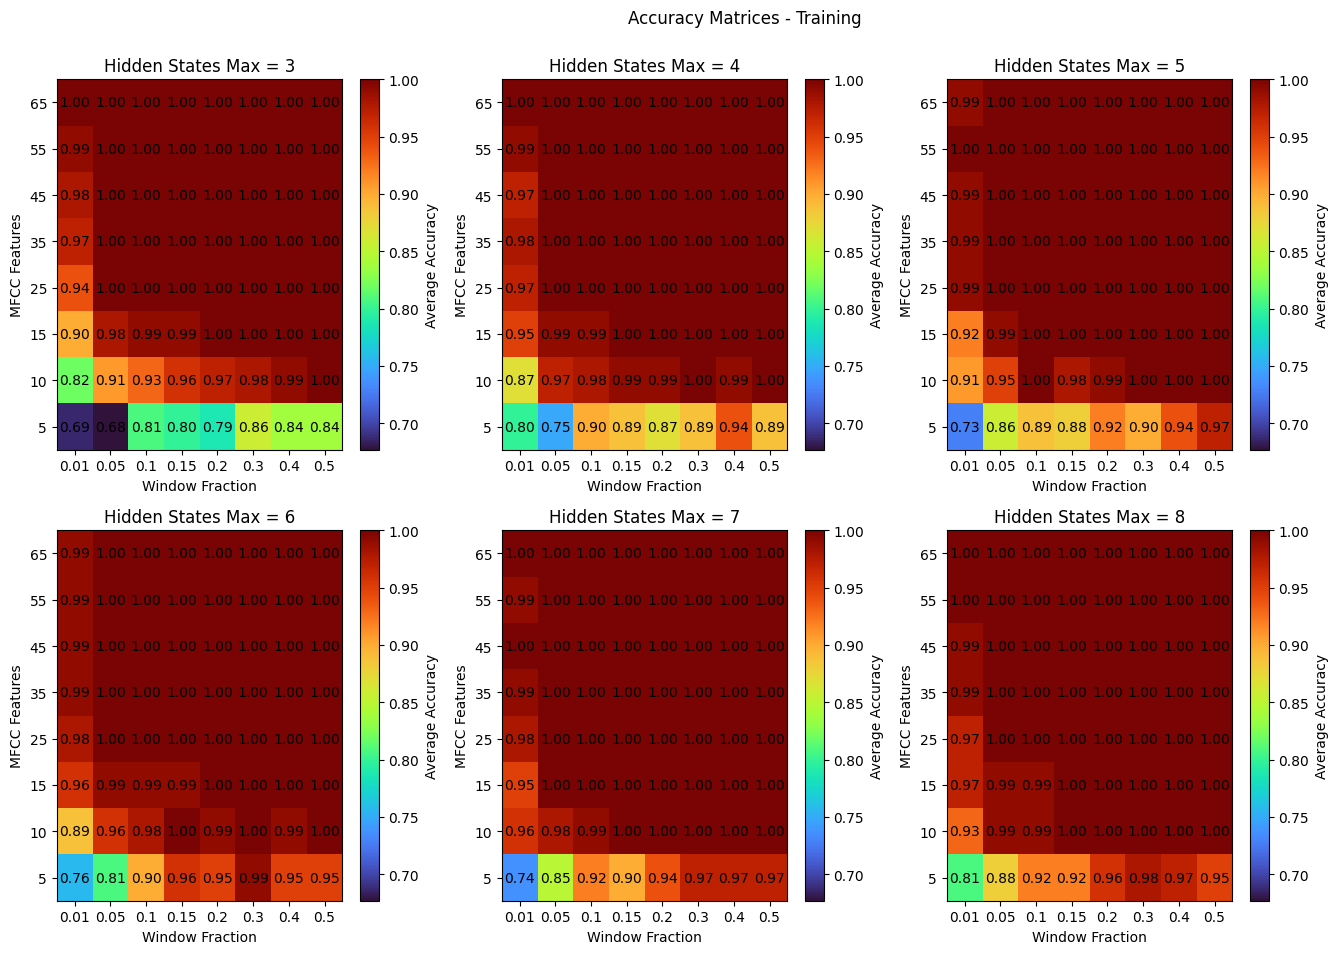

In [163]:
#accuracy matrices for different parameter combinations
# Calculate global minimum and maximum values across all hidden states
global_min_acc = []
global_max_acc = []
for hidden_states in hidden_states_set:
    global_min_acc.append(np.min(accuracies_train[hidden_states]))
    global_max_acc.append(np.max(accuracies_train[hidden_states]))
global_min_acc_val = min(global_min_acc)
global_max_acc_val = max(global_max_acc)

# Plotting Accuracy Matrices
num_cols = 3
num_cols = min(num_cols, len(hidden_states_set))
num_rows = int(np.ceil(len(hidden_states_set) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Accuracy Matrices - Training', y=0.95)

for hidx, hidden_states in enumerate(hidden_states_set):
    accuracy_matrix = accuracies_train[hidden_states]

    ax = axes.flatten()[hidx]
    im = ax.pcolormesh(np.arange(len(window_factor_set) + 1), np.arange(len(mfcc_features_set) + 1), accuracy_matrix, shading='auto', cmap='turbo', vmin=global_min_acc_val, vmax=global_max_acc_val)

    ax.set_xticks(np.arange(len(window_factor_set)) + 0.5)
    ax.set_yticks(np.arange(len(mfcc_features_set)) + 0.5)

    ax.set_xticklabels([str(i) for i in window_factor_set])
    ax.set_yticklabels([str(i) for i in mfcc_features_set])

    cbar = fig.colorbar(im, ax=ax, label='Average Accuracy')

    ax.set_xlabel('Window Fraction')
    ax.set_ylabel('MFCC Features')
    ax.set_title(f'Hidden States Max = {hidden_states}')

    # Add text annotations inside each box
    for i in range(len(window_factor_set)):
        for j in range(len(mfcc_features_set)):
            text = f'{accuracy_matrix[j][i]:.2f}'
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='black')

# Remove unused subplots
for i in range(len(hidden_states_set), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

The matrices above show the training accuracy for different parameter combinations. Besides a small number of MFCC features and/or very small window fractions, the training accuracy is very high.

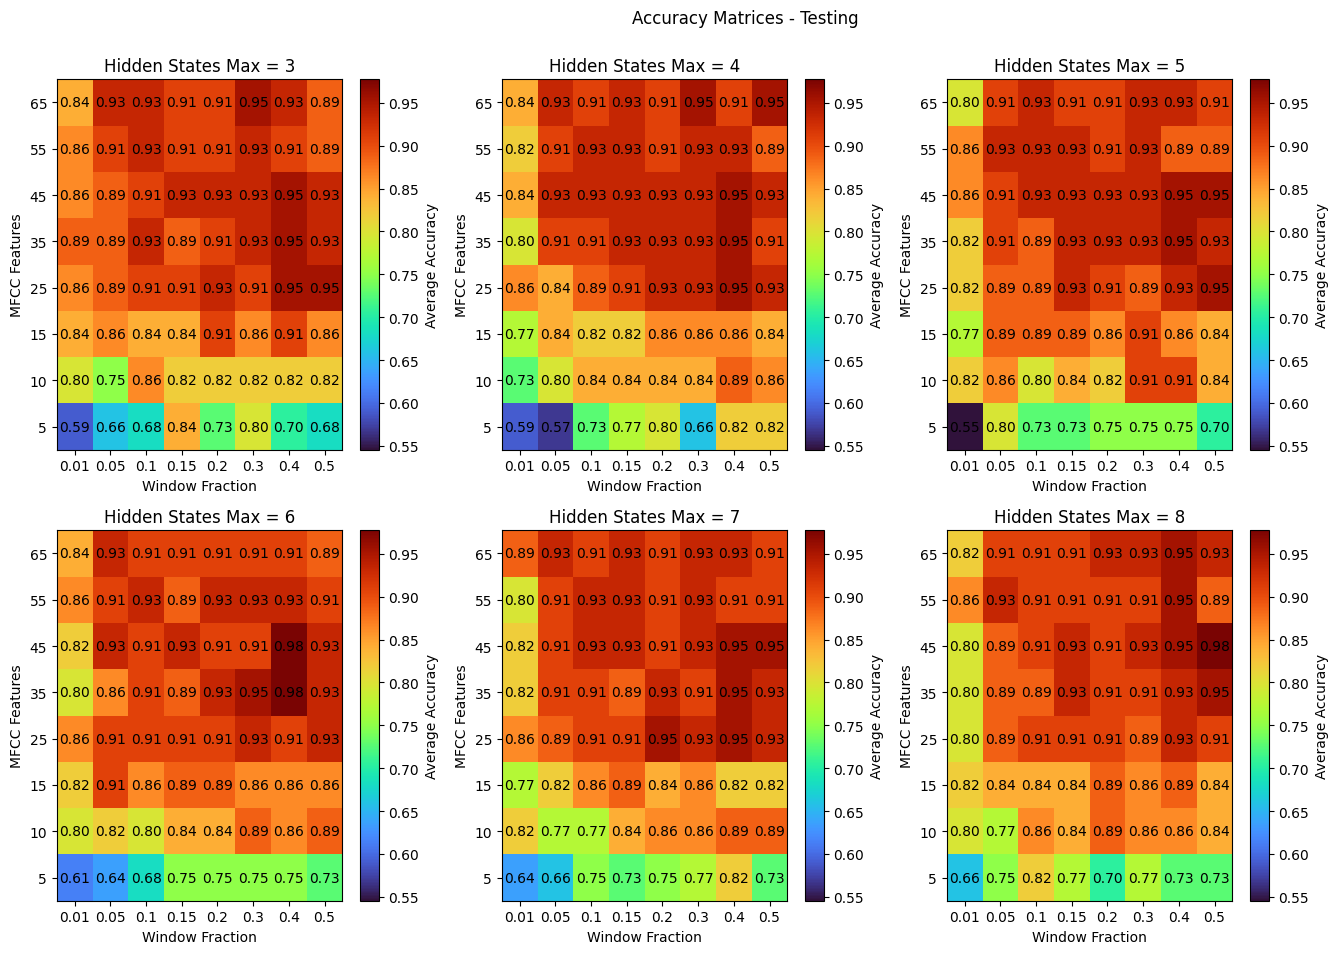

In [164]:
#accuracy matrices for different parameter combinations
# Calculate global minimum and maximum values across all hidden states
global_min_acc = []
global_max_acc = []
for hidden_states in hidden_states_set:
    global_min_acc.append(np.min(accuracies_test[hidden_states]))
    global_max_acc.append(np.max(accuracies_test[hidden_states]))
global_min_acc_val = min(global_min_acc)
global_max_acc_val = max(global_max_acc)

# Plotting Accuracy Matrices
num_cols = 3
num_cols = min(num_cols, len(hidden_states_set))
num_rows = int(np.ceil(len(hidden_states_set) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Accuracy Matrices - Testing', y=0.95)

for hidx, hidden_states in enumerate(hidden_states_set):
    accuracy_matrix = accuracies_test[hidden_states]

    ax = axes.flatten()[hidx]
    im = ax.pcolormesh(np.arange(len(window_factor_set) + 1), np.arange(len(mfcc_features_set) + 1), accuracy_matrix, shading='auto', cmap='turbo', vmin=global_min_acc_val, vmax=global_max_acc_val)

    ax.set_xticks(np.arange(len(window_factor_set)) + 0.5)
    ax.set_yticks(np.arange(len(mfcc_features_set)) + 0.5)

    ax.set_xticklabels([str(i) for i in window_factor_set])
    ax.set_yticklabels([str(i) for i in mfcc_features_set])

    cbar = fig.colorbar(im, ax=ax, label='Average Accuracy')

    ax.set_xlabel('Window Fraction')
    ax.set_ylabel('MFCC Features')
    ax.set_title(f'Hidden States Max = {hidden_states}')

    # Add text annotations inside each box
    for i in range(len(window_factor_set)):
        for j in range(len(mfcc_features_set)):
            text = f'{accuracy_matrix[j][i]:.2f}'
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='black')

# Remove unused subplots
for i in range(len(hidden_states_set), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

The matrices above show the testing accuracy for all the combinations of the parameters sets. We see that one the highest accuracies for all hidden states consistently appears at a $\texttt{window\_fraction}=0.4$ and $\texttt{mfcc\_features}=\{35,45\}$ (although a high accuracy is recorded at $\texttt{window\_fraction}=0.4$ and $\texttt{mfcc\_features}=45$). For the next set of experiments, we select $\texttt{window\_fraction}=0.4$ and the smaller number of MFCC features: $\texttt{mfcc\_features}=35$.

### Final Set of Experiments
Given the small size of the dataset, it is necessary to perform cross validation. When selecting observations to allocate for training and testing, I ensure that the training and testing datasets contain at least one real observation. This is done since the accuracy of the model suffers when it is trained exclusively on ideal observations resulting in a testing dataset with $3/4$ real observations.

<span style="color:yellow">Note:</span> do not run the cells below (the run-time is ~60 min)

In [35]:
def split_data_new(data, lengths, split):
    #fixed parameters
    objects = 11

    real_obs = [11,12,13]
    test_nums = []
    train_nums = []

    while((any(element in real_obs for element in train_nums) and any(element in real_obs for element in test_nums))==False):
        #compute the numbers of training/testing observations
        train_nums, test_nums = random_selection(split=split)

    print(train_nums)
    print(test_nums)

    train_data = {}
    test_data = {}

    train_lengths = {}
    test_lengths = {}

    for object_num in range(1, objects + 1):
        train_data[object_num] = []
        train_lengths[object_num] = []
        test_data[object_num] = []
        test_lengths[object_num] = []
        for obs in train_nums:
            train_data[object_num].append(data[(object_num, obs)])
            train_lengths[object_num].append(lengths[(object_num, obs)])
        for obs in test_nums:
            test_data[object_num].append(data[(object_num, obs)])
            test_lengths[object_num].append(lengths[(object_num, obs)])

    return train_data, test_data, train_lengths, test_lengths

In [243]:
mfcc_features = 35
window_factor = 0.4
hidden_states_set = [3,4,5,6,7,8]
n_iterations = 80

In [40]:
#experiment: vary the train/test observations sets - cross-validation
#parameter search (with parallelization)
class CrossValidator:
    def __init__(self, n_iterations, mfcc_features, window_factor):
        #fixed parameters
        self.objects = 11
        self.hop_factor = 0.2
        self.padding_factor = 2
        self.channel = 0
        self.scaling = True
        self.split = 0.7

        self.model_name = 'GaussianHMM'
        self.cov_type = 'tied'
        self.start_state = 1
        
        self.mfcc_features = mfcc_features
        self.window_factor = window_factor

        self.n_iterations = n_iterations
        
        self.accuracies_train = {}
        self.accuracies_test = {}

        for hidden_states in hidden_states_set:
            self.accuracies_train[hidden_states] = [0.0 for i in range(0, self.n_iterations)]
            self.accuracies_test[hidden_states] = [0.0 for i in range(0, self.n_iterations)]

        self.lock = threading.Lock()

    def update_accuracies(self, hidden_states, nidx, accuracy_train, accuracy_test):
        with self.lock:
            self.accuracies_train[hidden_states][nidx] = accuracy_train
            self.accuracies_test[hidden_states][nidx] = accuracy_test

    def process_instance(self, hidden_states, nidx):
        # Calculate accuracy_train and accuracy_test
        data, lengths = data_extraction(channel=self.channel,
                                        mfcc_features=self.mfcc_features,
                                        window_factor=self.window_factor,
                                        padding_factor=self.padding_factor,
                                        hop_factor=self.hop_factor,
                                        default_config=False,                                                        
                                        scaling=self.scaling) 

        train_data, test_data, train_lengths, _ = split_data_new(data=data,
                                                                 lengths=lengths, 
                                                                 split=self.split)
        
        train_data_concatenated = concatenate_data(train_data)                                                           

        trained_models, _ = model_training(hidden_states=hidden_states,
                                           model_name=self.model_name,
                                           cov_type=self.cov_type,
                                           start_state=self.start_state,
                                           train_data=train_data_concatenated,
                                           train_lengths=train_lengths)
            
        real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                      data=train_data)
            
        real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                    data=test_data)
            
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        
        # Update accuracies
        self.update_accuracies(hidden_states, nidx, accuracy_train, accuracy_test)


cv_experiment = CrossValidator(n_iterations=n_iterations, mfcc_features=mfcc_features, window_factor=window_factor)

# Number of threads to use (adjust as needed)
num_workers = 8

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Iterate over the combinations using the executor.map function
    futures = []
    for hidden_states in hidden_states_set:
        for nidx in range(0, n_iterations):
            future = executor.submit(cv_experiment.process_instance,
                                     hidden_states=hidden_states,
                                     nidx=nidx)
            futures.append(future)

    # Wait for all computations to finish
    concurrent.futures.wait(futures)

# Access the results using accuracy_matrix_updater.accuracies_train and accuracy_matrix_updater.accuracies_test
accuracies_test_cv = cv_experiment.accuracies_test
accuracies_train_cv = cv_experiment.accuracies_train

[4, 1, 5, 8, 7, 3, 12, 2, 13]
[11, 9, 6, 10]
[9, 3, 12, 6, 2, 13, 8, 4, 1]
[10, 7, 5, 11]
[5, 11, 9, 1, 4, 13, 8, 7, 6]
[10, 2, 3, 12]
[13, 10, 5, 3, 7, 12, 2, 4, 1]
[9, 11, 6, 8]
[2, 7, 6, 11, 9, 12, 5, 3, 1]
[8, 10, 13, 4]
[13, 7, 6, 10, 1, 4, 3, 2, 11]
[8, 9, 5, 12]
[6, 1, 7, 4, 3, 2, 13, 5, 11]
[9, 12, 8, 10]
[2, 13, 4, 1, 10, 8, 12, 7, 9]
[3, 6, 5, 11]
[7, 9, 3, 12, 6, 8, 2, 11, 10]
[1, 13, 4, 5]
[11, 3, 5, 4, 13, 10, 1, 9, 8]
[12, 6, 7, 2]
[4, 3, 10, 9, 2, 8, 11, 13, 5]
[7, 6, 1, 12]
[11, 6, 2, 8, 5, 3, 10, 9, 1]
[4, 13, 12, 7]
[5, 4, 3, 11, 13, 1, 8, 2, 10]
[7, 9, 6, 12]
[1, 4, 5, 8, 11, 9, 13, 2, 10]
[6, 12, 3, 7]
[2, 8, 11, 7, 9, 6, 12, 5, 3]
[13, 1, 10, 4]
[10, 2, 6, 9, 8, 4, 12, 7, 5]
[1, 3, 13, 11]
[10, 6, 9, 4, 13, 2, 5, 3, 1]
[8, 11, 12, 7]
[4, 1, 12, 2, 7, 11, 10, 3, 8]
[5, 13, 9, 6]
[9, 12, 1, 10, 6, 5, 11, 7, 2]
[13, 4, 8, 3]
[10, 11, 4, 6, 13, 3, 9, 8, 7]
[12, 2, 1, 5]
[11, 9, 5, 4, 7, 2, 8, 6, 12]
[13, 3, 10, 1]
[7, 5, 8, 3, 12, 10, 1, 4, 2]
[11, 13, 9, 6]
[13, 9, 10

Model is not converging.  Current: -8773.202813732396 is not greater than -8773.202813406293. Delta is -3.261029632994905e-07


[10, 7, 4, 1, 3, 12, 9, 2, 6]
[11, 13, 8, 5]
[11, 6, 13, 5, 2, 3, 7, 1, 10]
[12, 9, 8, 4]
[6, 10, 4, 11, 13, 2, 1, 9, 7]
[12, 3, 8, 5]
[6, 8, 1, 7, 10, 3, 11, 13, 9]
[5, 4, 2, 12]
[10, 5, 13, 8, 9, 4, 1, 11, 6]
[3, 12, 2, 7]
[5, 8, 1, 3, 6, 2, 12, 4, 10]
[9, 7, 13, 11]
[4, 9, 11, 1, 7, 12, 3, 10, 5]
[13, 2, 8, 6]
[5, 11, 9, 7, 8, 13, 4, 10, 6]
[2, 3, 1, 12]
[4, 1, 13, 10, 6, 9, 3, 12, 8]
[5, 2, 7, 11]
[1, 9, 3, 11, 5, 6, 2, 4, 8]
[12, 13, 10, 7]
[13, 5, 4, 9, 8, 7, 2, 12, 10]
[1, 11, 3, 6]
[3, 2, 12, 5, 8, 10, 6, 13, 4]
[1, 11, 7, 9]
[4, 10, 7, 12, 11, 8, 6, 3, 1]
[2, 13, 5, 9]
[4, 2, 9, 8, 6, 1, 13, 12, 10]
[11, 5, 7, 3]
[3, 11, 5, 13, 7, 8, 9, 1, 6]
[2, 12, 10, 4]
[8, 9, 11, 12, 6, 5, 2, 4, 10]
[3, 7, 13, 1]
[4, 3, 10, 5, 9, 1, 7, 11, 6]
[12, 13, 2, 8]
[5, 6, 11, 2, 7, 4, 12, 3, 9]
[1, 13, 10, 8]
[8, 6, 11, 12, 10, 4, 7, 3, 9]
[1, 13, 5, 2]
[1, 12, 2, 5, 3, 7, 9, 10, 13]
[4, 6, 8, 11]
[10, 4, 5, 6, 1, 8, 11, 13, 2]
[3, 12, 9, 7]
[10, 4, 1, 3, 7, 6, 11, 5, 2]
[13, 8, 12, 9]
[11, 8, 9,

Model is not converging.  Current: -7862.854697972121 is not greater than -7862.854697805015. Delta is -1.6710600903024897e-07


[5, 1, 6, 13, 4, 9, 3, 7, 8]
[12, 11, 2, 10]
[3, 1, 4, 9, 7, 10, 12, 2, 5]
[6, 11, 8, 13]
[7, 13, 5, 6, 4, 10, 8, 11, 3]
[12, 9, 2, 1]
[5, 9, 7, 11, 4, 2, 1, 8, 3]
[10, 13, 6, 12]
[10, 8, 9, 3, 1, 5, 11, 6, 12]
[4, 2, 13, 7]
[5, 1, 2, 10, 9, 8, 13, 4, 12]
[3, 6, 11, 7]
[9, 6, 2, 8, 5, 3, 7, 1, 13]
[4, 11, 10, 12]
[8, 13, 4, 6, 10, 3, 12, 1, 2]
[7, 9, 11, 5]
[1, 3, 7, 9, 6, 10, 2, 13, 11]
[12, 5, 8, 4]
[13, 11, 2, 1, 7, 8, 10, 6, 9]
[12, 5, 3, 4]
[12, 3, 6, 5, 7, 1, 8, 2, 4]
[10, 11, 9, 13]
[10, 8, 5, 2, 3, 7, 11, 9, 12]
[1, 4, 13, 6]
[6, 3, 9, 11, 1, 8, 13, 7, 5]
[12, 4, 2, 10]
[3, 12, 7, 13, 9, 5, 6, 1, 2]
[11, 10, 4, 8]
[4, 9, 12, 7, 1, 2, 13, 8, 5]
[11, 10, 6, 3]
[4, 5, 13, 9, 1, 2, 3, 6, 7]
[10, 12, 8, 11]
[4, 3, 7, 9, 8, 6, 12, 2, 11]
[13, 1, 5, 10]
[2, 11, 9, 4, 1, 5, 12, 6, 3]
[10, 13, 8, 7]
[13, 8, 9, 12, 1, 5, 6, 4, 7]
[10, 3, 11, 2]
[7, 11, 6, 2, 10, 9, 3, 8, 1]
[13, 5, 12, 4]
[7, 1, 2, 10, 3, 11, 5, 12, 9]
[8, 13, 6, 4]
[1, 12, 5, 6, 2, 10, 7, 11, 4]
[8, 9, 3, 13]
[2, 4, 8, 

Model is not converging.  Current: -9001.391143153338 is not greater than -9001.391143054754. Delta is -9.858376870397478e-08


[7, 5, 3, 6, 11, 10, 1, 13, 2]
[9, 12, 8, 4]
[8, 6, 1, 10, 5, 13, 3, 12, 4]
[9, 7, 11, 2]
[4, 13, 7, 3, 2, 11, 1, 6, 10]
[8, 12, 9, 5]
[11, 5, 3, 4, 9, 8, 2, 6, 10]
[7, 1, 13, 12]
[11, 1, 13, 6, 10, 5, 8, 3, 7]
[9, 4, 12, 2]
[8, 9, 2, 5, 6, 13, 3, 4, 1]
[12, 10, 7, 11]
[11, 10, 2, 4, 5, 6, 12, 9, 3]
[8, 1, 7, 13]
[4, 10, 2, 7, 5, 8, 13, 3, 1]
[12, 9, 11, 6]
[10, 12, 9, 7, 3, 4, 6, 5, 11]
[2, 8, 1, 13]
[11, 1, 4, 10, 5, 8, 3, 7, 12]
[13, 2, 9, 6]
[9, 12, 4, 7, 5, 11, 8, 3, 6]
[1, 2, 13, 10]
[5, 2, 9, 13, 4, 1, 7, 12, 6]
[10, 3, 11, 8]
[6, 3, 1, 13, 5, 12, 8, 9, 4]
[11, 2, 10, 7]
[5, 11, 10, 1, 12, 9, 6, 4, 2]
[13, 3, 8, 7]
[7, 5, 2, 4, 1, 8, 9, 13, 10]
[3, 11, 12, 6]
[13, 1, 8, 3, 9, 5, 12, 2, 6]
[11, 7, 10, 4]
[9, 6, 10, 5, 11, 4, 1, 7, 12]
[13, 2, 3, 8]
[8, 2, 4, 6, 10, 7, 11, 9, 3]
[1, 12, 5, 13]
[6, 13, 10, 7, 3, 1, 12, 4, 5]
[9, 11, 2, 8]
[3, 13, 10, 4, 1, 6, 2, 8, 7]
[12, 11, 9, 5]
[2, 12, 3, 4, 13, 10, 9, 5, 6]
[1, 8, 11, 7]
[10, 8, 13, 2, 5, 7, 4, 1, 12]
[6, 11, 3, 9]
[1, 8, 5, 

Model is not converging.  Current: -8183.384391715681 is not greater than -8183.384391676181. Delta is -3.9500264392700046e-08


[10, 12, 9, 2, 7, 5, 13, 4, 1]
[6, 11, 8, 3]
[6, 7, 3, 8, 9, 2, 4, 5, 12]
[13, 1, 10, 11]
[4, 8, 10, 12, 7, 11, 1, 9, 3]
[13, 6, 5, 2]
[6, 5, 4, 2, 11, 8, 12, 7, 10]
[13, 3, 9, 1]
[1, 13, 5, 8, 7, 10, 9, 6, 3]
[12, 4, 11, 2]
[1, 3, 6, 5, 13, 8, 10, 12, 2]
[7, 4, 11, 9]
[8, 13, 9, 12, 5, 3, 6, 4, 7]
[11, 10, 2, 1]
[7, 6, 8, 2, 1, 12, 5, 4, 13]
[10, 11, 3, 9]
[6, 3, 8, 13, 4, 12, 10, 9, 7]
[11, 1, 5, 2]


Model is not converging.  Current: -7844.376786077936 is not greater than -7844.376785660287. Delta is -4.176490620011464e-07


[6, 10, 4, 9, 7, 3, 11, 8, 13]
[5, 2, 12, 1]
[7, 6, 9, 4, 1, 12, 8, 5, 11]
[10, 2, 13, 3]
[9, 2, 6, 10, 7, 5, 12, 1, 3]
[8, 11, 4, 13]
[7, 3, 2, 6, 8, 9, 12, 11, 4]
[1, 5, 10, 13]
[5, 2, 4, 11, 1, 9, 13, 3, 6]
[8, 10, 12, 7]
[5, 4, 11, 10, 2, 7, 13, 8, 1]
[9, 3, 12, 6]
[9, 10, 6, 13, 8, 1, 4, 11, 3]
[12, 5, 7, 2]
[6, 8, 13, 4, 1, 10, 3, 7, 2]
[12, 5, 11, 9]
[8, 12, 9, 4, 6, 7, 10, 5, 11]
[2, 13, 1, 3]
[13, 5, 10, 6, 3, 1, 2, 8, 4]
[9, 11, 12, 7]
[7, 2, 5, 13, 10, 8, 6, 9, 11]
[1, 4, 3, 12]
[4, 1, 3, 6, 8, 9, 10, 2, 12]
[7, 13, 11, 5]
[10, 12, 4, 11, 8, 1, 2, 3, 5]
[6, 13, 9, 7]
[7, 12, 3, 5, 9, 6, 8, 4, 11]
[10, 1, 2, 13]
[4, 11, 8, 2, 5, 12, 9, 3, 10]
[13, 6, 1, 7]


Model is not converging.  Current: -8682.252851319405 is not greater than -8682.252851299289. Delta is -2.0116203813813627e-08


[2, 4, 6, 9, 8, 12, 11, 3, 10]
[7, 13, 1, 5]
[13, 4, 8, 5, 7, 2, 6, 3, 9]
[12, 10, 11, 1]
[13, 5, 3, 1, 11, 10, 7, 8, 4]
[6, 12, 2, 9]


Model is not converging.  Current: -8359.478078221446 is not greater than -8359.478078198319. Delta is -2.312663127668202e-08


[11, 13, 5, 10, 4, 7, 8, 3, 1]
[9, 6, 12, 2]


Model is not converging.  Current: -8533.116423750578 is not greater than -8533.116422983398. Delta is -7.671806088183075e-07


[9, 11, 2, 5, 12, 10, 8, 7, 6]
[4, 1, 13, 3]
[8, 11, 13, 9, 1, 2, 6, 10, 5]
[12, 7, 4, 3]
[10, 2, 13, 9, 3, 6, 1, 4, 12]
[11, 7, 8, 5]
[11, 1, 7, 10, 2, 3, 9, 8, 5]
[4, 13, 6, 12]
[11, 5, 9, 13, 8, 6, 7, 10, 1]
[3, 12, 4, 2]
[11, 9, 12, 5, 4, 3, 1, 6, 10]
[13, 7, 2, 8]
[8, 12, 1, 13, 4, 5, 2, 9, 10]
[6, 7, 3, 11]
[3, 11, 6, 10, 7, 2, 4, 9, 8]
[12, 13, 1, 5]
[5, 7, 10, 9, 12, 1, 3, 13, 6]
[8, 2, 4, 11]
[7, 4, 1, 9, 11, 6, 13, 3, 2]
[10, 12, 5, 8]
[9, 12, 10, 1, 4, 6, 3, 7, 2]
[13, 5, 8, 11]
[10, 7, 9, 11, 2, 6, 3, 5, 12]
[13, 1, 4, 8]
[4, 5, 11, 9, 2, 7, 10, 6, 8]
[13, 1, 3, 12]
[4, 13, 5, 6, 7, 3, 10, 2, 11]
[1, 12, 9, 8]
[9, 2, 11, 8, 6, 3, 1, 10, 5]
[12, 4, 13, 7]
[9, 5, 3, 6, 11, 2, 13, 1, 7]
[8, 4, 10, 12]


Model is not converging.  Current: -8575.100200135115 is not greater than -8575.10020009088. Delta is -4.4236003304831684e-08


[9, 5, 10, 7, 6, 8, 3, 4, 13]
[2, 11, 12, 1]
[13, 12, 5, 1, 3, 9, 6, 2, 7]
[11, 8, 4, 10]
[9, 6, 2, 11, 13, 3, 10, 8, 4]
[1, 5, 7, 12]
[6, 3, 13, 5, 9, 4, 11, 1, 2]
[12, 7, 10, 8]
[10, 9, 1, 3, 2, 13, 4, 11, 6]
[5, 7, 12, 8]
[7, 10, 8, 13, 3, 4, 1, 6, 2]
[9, 11, 12, 5]
[11, 8, 3, 10, 1, 12, 2, 4, 9]
[13, 7, 6, 5]
[10, 8, 7, 2, 5, 3, 9, 11, 6]
[12, 1, 4, 13]


Model is not converging.  Current: -8653.44300692702 is not greater than -8653.443006047397. Delta is -8.796232577878982e-07


[11, 9, 5, 4, 6, 3, 12, 10, 8]
[2, 13, 1, 7]
[4, 9, 11, 8, 5, 12, 3, 2, 10]
[7, 13, 1, 6]
[1, 12, 11, 5, 8, 7, 3, 9, 6]
[2, 10, 13, 4]
[6, 12, 9, 8, 5, 7, 10, 13, 3]
[1, 11, 4, 2]
[11, 6, 4, 9, 1, 10, 8, 13, 5]
[12, 7, 3, 2]
[5, 13, 12, 4, 8, 3, 6, 2, 7]
[9, 11, 1, 10]
[7, 6, 13, 9, 10, 8, 3, 11, 2]
[12, 1, 4, 5]
[2, 11, 6, 8, 10, 9, 1, 5, 13]
[12, 3, 7, 4]
[4, 6, 2, 8, 7, 10, 1, 13, 11]
[5, 9, 12, 3]
[5, 6, 12, 3, 13, 10, 4, 9, 7]
[11, 8, 2, 1]
[5, 8, 6, 10, 13, 3, 9, 7, 11]
[12, 2, 4, 1]
[4, 3, 7, 11, 1, 8, 6, 5, 13]
[2, 10, 9, 12]
[9, 2, 8, 10, 1, 5, 13, 3, 4]
[7, 11, 6, 12]
[10, 2, 11, 1, 3, 4, 6, 5, 8]
[7, 12, 9, 13]
[6, 8, 7, 11, 1, 5, 12, 4, 3]
[2, 10, 9, 13]
[1, 5, 3, 4, 10, 6, 9, 11, 12]
[2, 8, 13, 7]


Model is not converging.  Current: -8676.088769397073 is not greater than -8676.088769319624. Delta is -7.744893082417548e-08


[11, 6, 9, 10, 2, 13, 4, 3, 7]
[8, 12, 1, 5]
[11, 2, 7, 4, 10, 6, 8, 13, 3]
[9, 5, 12, 1]
[2, 4, 9, 13, 6, 3, 7, 12, 10]
[5, 1, 8, 11]
[6, 1, 7, 3, 12, 5, 9, 10, 2]
[4, 11, 8, 13]
[9, 2, 3, 1, 4, 5, 7, 12, 10]
[13, 11, 6, 8]


Model is not converging.  Current: -8419.577716513473 is not greater than -8419.577716366126. Delta is -1.473472366342321e-07


[13, 3, 9, 1, 2, 11, 6, 7, 10]
[8, 5, 4, 12]
[1, 4, 3, 6, 9, 13, 5, 7, 11]
[8, 2, 10, 12]
[7, 5, 1, 9, 3, 10, 11, 8, 2]
[6, 12, 4, 13]
[1, 7, 13, 12, 9, 5, 10, 2, 4]
[3, 6, 11, 8]
[12, 1, 2, 7, 8, 4, 10, 13, 9]
[5, 6, 3, 11]


Model is not converging.  Current: -8947.594569093302 is not greater than -8947.594569036677. Delta is -5.662514013238251e-08


[1, 5, 9, 10, 7, 2, 13, 3, 11]
[8, 6, 12, 4]
[11, 10, 2, 3, 1, 8, 5, 4, 9]
[12, 6, 13, 7]
[1, 5, 2, 7, 11, 9, 12, 6, 4]
[13, 10, 3, 8]
[5, 6, 1, 7, 8, 3, 11, 13, 2]
[10, 12, 4, 9]


Model is not converging.  Current: -8544.315330956233 is not greater than -8544.315330723808. Delta is -2.324250090168789e-07


[11, 3, 2, 10, 13, 5, 1, 6, 4]
[8, 9, 12, 7]
[8, 3, 2, 5, 6, 12, 11, 4, 10]
[9, 13, 1, 7]
[11, 4, 12, 10, 1, 2, 7, 3, 5]
[9, 13, 6, 8]
[10, 3, 8, 12, 5, 9, 7, 11, 6]
[1, 13, 2, 4]
[9, 2, 1, 12, 3, 4, 10, 11, 6]
[5, 7, 13, 8]
[5, 8, 9, 12, 6, 2, 1, 4, 11]
[7, 10, 3, 13]
[8, 7, 12, 9, 11, 5, 6, 10, 1]
[13, 4, 2, 3]


Model is not converging.  Current: -8364.253535180567 is not greater than -8364.25353411142. Delta is -1.069147401722148e-06


[10, 4, 11, 7, 3, 1, 6, 5, 12]
[2, 9, 13, 8]
[12, 13, 3, 9, 1, 6, 5, 4, 7]
[2, 11, 10, 8]
[13, 10, 5, 7, 9, 8, 11, 4, 3]
[2, 6, 12, 1]
[12, 6, 9, 2, 1, 11, 10, 3, 7]
[5, 8, 4, 13]
[12, 10, 5, 8, 2, 7, 13, 4, 9]
[6, 3, 1, 11]
[11, 5, 1, 7, 9, 10, 4, 8, 3]
[6, 2, 13, 12]
[11, 1, 6, 2, 8, 9, 3, 4, 13]
[7, 12, 5, 10]
[3, 4, 6, 8, 1, 10, 7, 2, 11]
[9, 12, 13, 5]
[3, 4, 11, 6, 13, 8, 1, 2, 10]
[5, 12, 9, 7]


Model is not converging.  Current: -8808.79040838562 is not greater than -8808.790408131972. Delta is -2.536471583880484e-07


[5, 13, 4, 3, 9, 12, 10, 6, 1]
[8, 2, 7, 11]
[6, 5, 12, 9, 4, 7, 10, 2, 13]
[11, 3, 8, 1]
[2, 6, 4, 12, 5, 13, 1, 8, 3]
[9, 11, 10, 7]
[12, 8, 11, 2, 6, 1, 5, 10, 7]
[4, 3, 13, 9]
[10, 4, 9, 1, 7, 6, 11, 2, 13]
[8, 5, 12, 3]
[9, 2, 10, 1, 4, 6, 7, 11, 5]
[12, 3, 13, 8]
[1, 6, 10, 13, 5, 7, 2, 9, 11]
[8, 12, 3, 4]
[7, 2, 6, 9, 3, 5, 13, 11, 10]
[12, 8, 1, 4]
[6, 2, 8, 4, 11, 9, 5, 3, 7]
[13, 1, 10, 12]
[5, 13, 6, 3, 1, 2, 12, 7, 9]
[4, 11, 10, 8]
[13, 2, 1, 3, 11, 5, 7, 8, 10]
[9, 12, 6, 4]
[10, 12, 4, 3, 9, 6, 1, 8, 5]
[13, 11, 7, 2]
[5, 7, 10, 2, 4, 8, 3, 9, 12]
[11, 6, 1, 13]
[8, 13, 11, 7, 4, 6, 5, 10, 9]
[1, 12, 2, 3]
[5, 4, 8, 3, 10, 7, 6, 9, 13]
[11, 12, 2, 1]
[4, 2, 5, 8, 9, 13, 11, 1, 3]
[7, 6, 10, 12]
[9, 12, 2, 4, 6, 3, 10, 7, 11]
[1, 13, 5, 8]
[9, 11, 12, 10, 6, 1, 3, 2, 8]
[7, 13, 4, 5]
[1, 2, 11, 7, 5, 4, 12, 10, 6]
[3, 8, 9, 13]
[6, 12, 5, 10, 4, 3, 7, 9, 1]
[8, 2, 11, 13]
[8, 9, 7, 5, 12, 11, 3, 2, 10]
[4, 6, 1, 13]
[10, 3, 4, 9, 2, 12, 11, 8, 6]
[13, 5, 7, 1]
[1, 10, 12

Model is not converging.  Current: -8608.821370978807 is not greater than -8608.82136893167. Delta is -2.0471361494855955e-06
Model is not converging.  Current: -8381.67742304217 is not greater than -8381.677421091425. Delta is -1.950746082002297e-06


[10, 4, 13, 8, 5, 3, 1, 9, 7]
[11, 12, 2, 6]
[1, 9, 2, 11, 7, 5, 4, 3, 8]
[13, 10, 12, 6]
[8, 10, 11, 7, 13, 1, 6, 2, 3]
[12, 5, 4, 9]
[10, 13, 9, 7, 4, 5, 12, 3, 2]
[11, 8, 1, 6]
[6, 9, 13, 10, 5, 7, 11, 3, 4]
[2, 12, 1, 8]
[1, 10, 3, 4, 8, 13, 9, 5, 2]
[11, 6, 7, 12]
[7, 9, 1, 10, 13, 6, 12, 8, 2]
[11, 4, 5, 3]
[1, 12, 10, 2, 13, 4, 9, 7, 6]
[3, 11, 5, 8]
[3, 10, 5, 6, 13, 7, 9, 4, 8]
[12, 1, 2, 11]
[5, 10, 1, 11, 7, 8, 3, 6, 13]
[9, 12, 2, 4]
[1, 7, 3, 6, 13, 4, 8, 5, 10]
[2, 12, 9, 11]
[10, 1, 5, 3, 9, 4, 7, 12, 6]
[8, 2, 13, 11]
[11, 9, 10, 7, 13, 5, 1, 8, 2]
[3, 6, 4, 12]
[5, 12, 4, 1, 6, 9, 10, 8, 13]
[7, 3, 11, 2]
[4, 7, 6, 1, 8, 11, 12, 10, 2]
[13, 3, 5, 9]
[13, 9, 10, 8, 5, 2, 1, 4, 3]
[11, 6, 7, 12]
[2, 9, 6, 11, 4, 8, 7, 5, 13]
[3, 12, 10, 1]
[3, 8, 11, 12, 4, 7, 10, 9, 1]
[5, 6, 2, 13]
[7, 4, 8, 5, 6, 1, 11, 12, 2]
[9, 3, 13, 10]
[2, 12, 8, 6, 4, 13, 3, 1, 10]
[9, 11, 7, 5]
[11, 12, 6, 2, 4, 3, 9, 7, 5]
[13, 1, 10, 8]
[9, 11, 10, 7, 8, 4, 1, 6, 12]
[3, 2, 5, 13]
[1, 7, 13,

Model is not converging.  Current: -8374.859507564945 is not greater than -8374.859507534034. Delta is -3.091008693445474e-08


[5, 6, 9, 4, 1, 10, 11, 2, 13]
[7, 12, 8, 3]
[13, 5, 8, 6, 1, 12, 9, 3, 2]
[11, 10, 4, 7]
[5, 12, 6, 4, 1, 7, 8, 3, 9]
[2, 10, 11, 13]
[9, 6, 8, 4, 3, 12, 10, 5, 1]
[13, 2, 7, 11]
[11, 4, 6, 12, 2, 7, 8, 10, 1]
[13, 5, 9, 3]
[12, 9, 10, 6, 8, 13, 5, 7, 1]
[3, 2, 4, 11]
[8, 7, 6, 9, 11, 2, 4, 1, 12]
[10, 3, 13, 5]
[7, 8, 6, 11, 3, 2, 10, 4, 12]
[9, 1, 13, 5]
[11, 3, 12, 6, 5, 8, 1, 9, 10]
[13, 2, 4, 7]
[12, 7, 6, 10, 1, 4, 2, 11, 3]
[5, 13, 9, 8]
[3, 11, 2, 10, 9, 6, 8, 7, 1]
[5, 12, 4, 13]
[11, 12, 9, 3, 10, 5, 2, 4, 6]
[1, 7, 13, 8]
[13, 10, 8, 2, 1, 6, 4, 12, 7]
[3, 5, 9, 11]


In [41]:
np.save('search/accuracies_train_cv_3.npy', accuracies_train_cv)
np.save('search/accuracies_test_cv_3.npy', accuracies_test_cv)

In [244]:
#...cv - experiment with 30 iterations, 4 hidden states
#...cv_2 - experiments with 60 iterations, 4 hidden states
#...cv_3 - experiment with 80 iterations, 6 hidden states
enum = 3
accuracies_train_cv = np.load(f'search/accuracies_train_cv_{enum}.npy', allow_pickle=True).item()
accuracies_test_cv = np.load(f'search/accuracies_test_cv_{enum}.npy', allow_pickle=True).item()

In [245]:
#compute average accuracy for each value of the number of hidden states across all starting seeds
average_accuracies_test = []
std_accuracies_test = []
#---------------------------
average_accuracies_train = []
std_accuracies_train = []

for hidden_states in hidden_states_set:
    avg = 0
    std_array = []
    for nidx in range(0, n_iterations):
        avg += accuracies_test_cv[hidden_states][nidx]
        std_array.append(accuracies_test_cv[hidden_states][nidx])
    std_accuracies_test.append(statistics.stdev(std_array))
    average_accuracies_test.append(avg/n_iterations)

for hidden_states in hidden_states_set:
    avg = 0
    std_array = []
    for nidx in range(0, n_iterations):
        avg += accuracies_train_cv[hidden_states][nidx]
        std_array.append(accuracies_train_cv[hidden_states][nidx])
    std_accuracies_train.append(statistics.stdev(std_array))
    average_accuracies_train.append(avg/n_iterations)

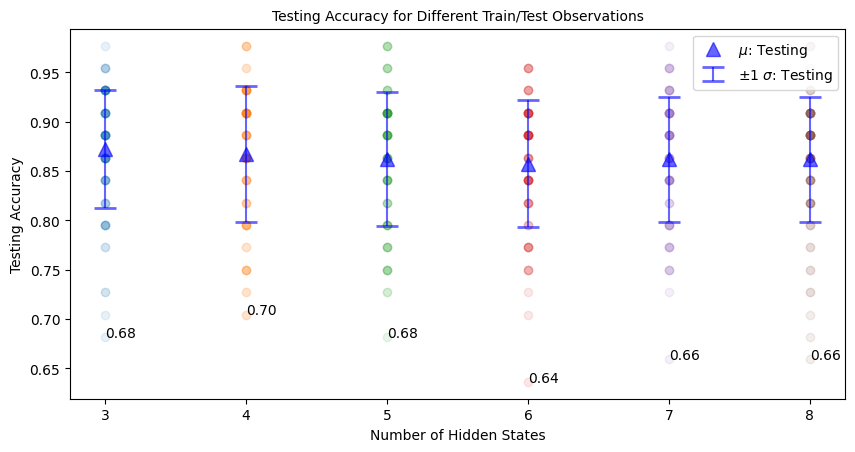

In [259]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes.set_title("Testing Accuracy for Different Train/Test Observations", fontsize=10)

axes.plot(hidden_states_set, average_accuracies_test, '^', markersize=10, color='blue', alpha=0.6, label='$\mu$: Testing')
axes.errorbar(hidden_states_set, average_accuracies_test, yerr=std_accuracies_test, fmt='none', ecolor='blue', alpha=0.6, capsize=8, capthick=2, label='$\pm 1~\sigma$: Testing')
for hidden_states in hidden_states_set:
    axes.scatter(np.ones(n_iterations)*hidden_states, accuracies_test_cv[hidden_states], marker='o', alpha=0.1)
    min_val = min(accuracies_test_cv[hidden_states])
    axes.annotate(f'{min_val:.2f}', xy=(hidden_states, min_val))

axes.set_xticks(hidden_states_set)
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Testing Accuracy")
axes.legend(loc='upper right')
plt.show()

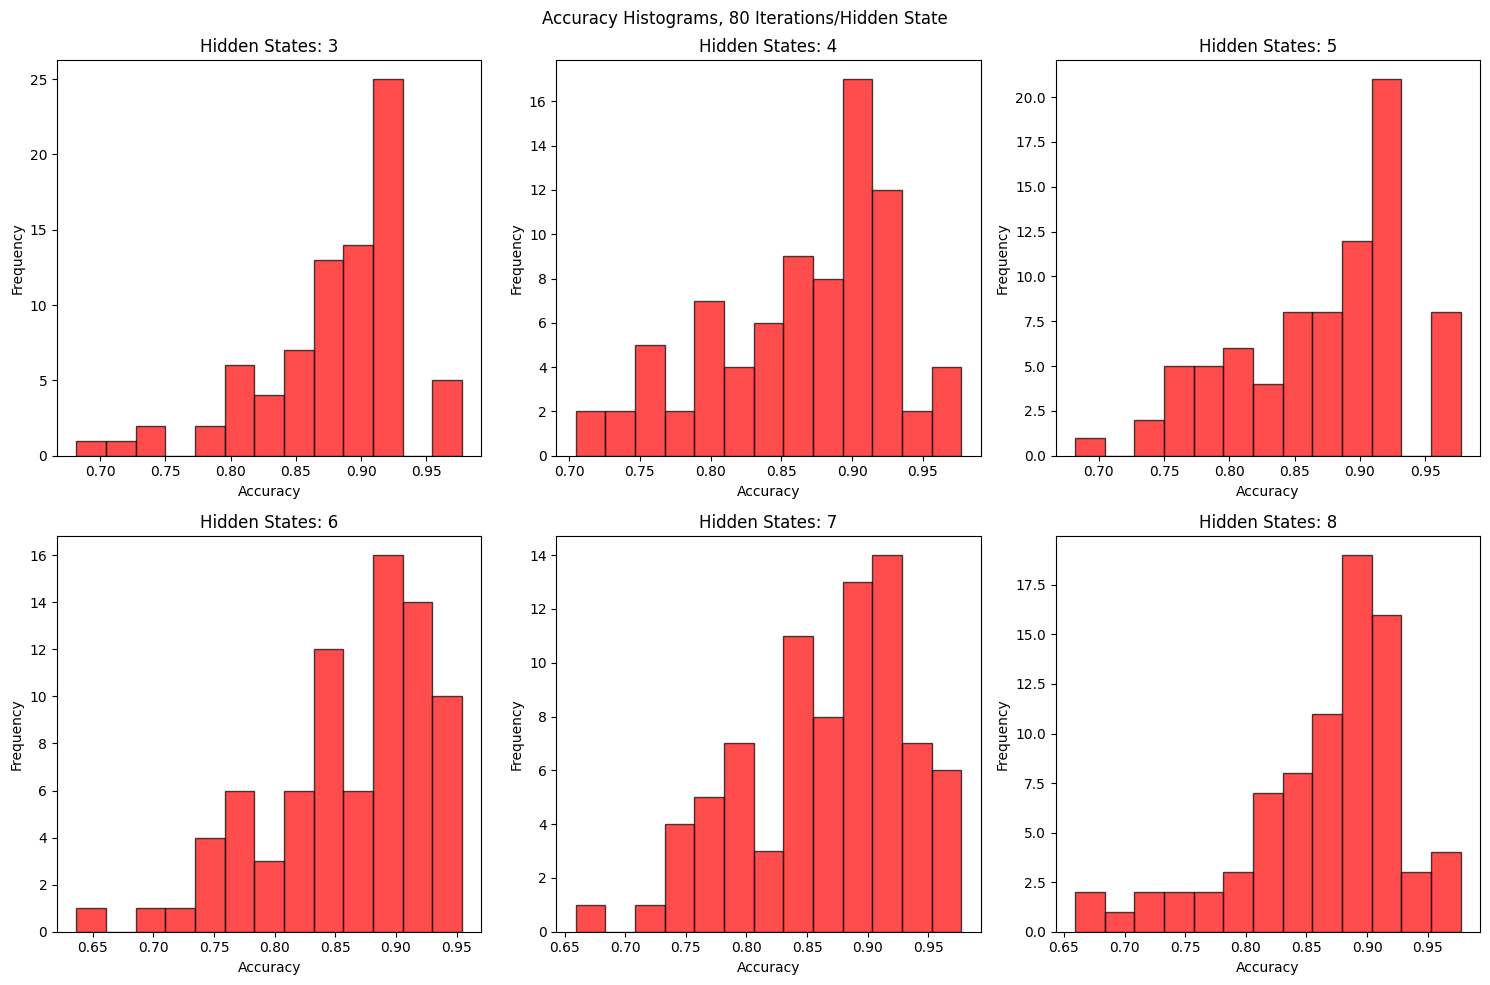

In [267]:
n_bins = 13

# User-defined number of columns for subplots
num_columns = 3

# Calculate the number of rows based on the number of hidden states
num_hidden_states = len(accuracies_test_cv)
num_rows = (len(hidden_states_set) + num_columns - 1) // num_columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
fig.suptitle('Accuracy Histograms, 80 Iterations/Hidden State')
# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over hidden states and create histograms
for i, (hidden_state, accuracies) in enumerate(accuracies_test_cv.items()):
    # Select the current subplot
    ax = axes[i]

    # Create the histogram
    ax.hist(accuracies, bins=n_bins, edgecolor='black', alpha=0.7, color='red')

    # Set labels and title
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Hidden States: {hidden_state}')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [257]:
formatted_accuracies = [f'{accuracy:.3f}' for accuracy in average_accuracies_test]
formatted_string = ', '.join(formatted_accuracies)
formatted_std = [f'{std:.3f}' for std in std_accuracies_test]
formatted_string_std = ', '.join(formatted_std)

print(f'Mean: {formatted_string}')
print(f'Standard Deviations: {formatted_string_std}')

Mean: 0.872, 0.867, 0.862, 0.858, 0.862, 0.862
Standard Deviations: 0.060, 0.069, 0.068, 0.064, 0.064, 0.063


The results of the cross-validation experiment indicates the mean accuracies are consistently above 85% for all the hidden states studied. However, it is important to note that the spread of the data is large; the standard deviation is consistently between 6-7% for all the hidden states studied. Furthermore, there are multiple trials with accuracies around 65%. The best case scenario is obtained for four hidden states where the minimum accuracy achieved is 70% ($\mu = 87\%, \sigma = 6.9\%$). Observing the histograms, we note that accuracies tend to be skewed to the right (i.e. towards higher accuracies) however we would caution making any conclusions based on the small size of the dataset.

### Conclusion
We have shown that it is possible to use vibration data and HMMs to classify objects. Even in the worst case scenario (accuracies around 65% from the cross-validation experiment), the accuracy of the classifier is better than random chance ($1/7 = 14.3\%$). We hypothesis that the structure of the HMM captures underlying state transitions in the frequency-domain representation of vibration data. We first showed this qualitatively by identifying distinct variations in the MFCC components for each object in the dataset. We also showed that increasing the number of hidden-states leads to larger non-zero elements in the transition probability matrix.

Although the results are promising, it is important to note that the dataset used for training and testing was small (only 13 observation per object, 144 total observations). To account for the limited availability of data, a cross-validation experiment was conducted. The results indicate the mean accuracies are above 85% for all the hidden states studied with standard deviation consistently between 6-7% and accuracies from multiple trials around 65%. It is also important to consider why the average performance of the model is consistent across all the hidden states ($\texttt{hidden\_states} \in \{3,4,5,6,7,8\}$). We hypothesis this is because for models with a higher number of hidden states, certain states become redundant and therefore the performance of these models approaches that of models with fewer hidden states.

Future studies should involve a larger dataset and a wider parameter search. A larger dataset would also likely reveal which number of hidden states captures the transition dynamics of the problem. 